## 1. 생육 데이터 EDA

아래 한글 폰트설치 후, 주석처리하고나서 런타임 재실행해야 합니다.

In [ ]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [ ]:
import numpy as np
import random
import os
import math

from glob import glob
import pandas as pd
import cv2
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchvision.models as models
from torchvision import transforms
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as img

plt.rc('font', family='NanumBarunGothic') 
mpl.rc('axes', unicode_minus=False)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/팀우이홍황')

Mounted at /content/drive


In [ ]:
% pwd

'/content/drive/.shortcut-targets-by-id/1NC2JH5s0D1GFYeHzJWvrxiUsDpQ_eMfR/팀우이홍황'

In [ ]:
# def seed_everything(seed):
#     random.seed(seed)
#     os.environ['PYTHONHASHSEED'] = str(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = True

# seed_everything(CFG['SEED']) # Seed 고정

### 1.1 데이터 로딩 

In [ ]:
def get_train_data(data_dir):
    img_path_list = []
    meta_list = []
    label_list = []

    for case_name in sorted(os.listdir(data_dir), key = str):
        current_path = os.path.join(data_dir, case_name)
        if os.path.isdir(current_path):
            # get image path
            img_path_list.append(sorted(glob(os.path.join(current_path, 'image', '*g'))))
          
            # get meta path
            meta_list.append(sorted(glob(os.path.join(current_path, 'meta', '*.csv'))))

            # get label
            label_df = pd.read_csv(current_path+'/label.csv')
            label_list.append(label_df)
                
    return img_path_list, meta_list, label_list

def get_test_data(data_dir):
    # get image path
    img_path_list = sorted(glob(os.path.join(data_dir, 'image', '*g')))
    # get meta path 
    meta_path_list = sorted(glob(os.path.join(data_dir, 'meta', '*.csv')))
    return img_path_list, meta_path_list

In [ ]:
all_img_path, all_meta, all_label = get_train_data('./dataset/train')
test_img_path , test_meta_path = get_test_data('./dataset/test')

#### 1) 로딩 데이터 페어 확인
학습 데이터를 먼저 확인하면

In [ ]:
len(all_img_path), len(all_meta), len(all_label)

(75, 75, 75)

In [ ]:
for i in range(75):
    if (len(all_img_path[i]) == len(all_meta[i])) and (len(all_img_path[i]) == len(all_label[i])):
        pass
    else:
        print(i)

In [ ]:
idx = 8

In [ ]:
print(all_img_path[idx])
print(all_meta[idx])
print(all_label[idx])

['./dataset/train/CASE09/image/CASE09_01.jpg', './dataset/train/CASE09/image/CASE09_02.jpg', './dataset/train/CASE09/image/CASE09_03.jpg', './dataset/train/CASE09/image/CASE09_04.jpg', './dataset/train/CASE09/image/CASE09_05.jpg', './dataset/train/CASE09/image/CASE09_06.jpg', './dataset/train/CASE09/image/CASE09_07.jpg', './dataset/train/CASE09/image/CASE09_08.jpg', './dataset/train/CASE09/image/CASE09_09.jpg']
['./dataset/train/CASE09/meta/CASE09_01.csv', './dataset/train/CASE09/meta/CASE09_02.csv', './dataset/train/CASE09/meta/CASE09_03.csv', './dataset/train/CASE09/meta/CASE09_04.csv', './dataset/train/CASE09/meta/CASE09_05.csv', './dataset/train/CASE09/meta/CASE09_06.csv', './dataset/train/CASE09/meta/CASE09_07.csv', './dataset/train/CASE09/meta/CASE09_08.csv', './dataset/train/CASE09/meta/CASE09_09.csv']
        img_name  leaf_weight
0  CASE09_01.jpg      232.012
1  CASE09_02.jpg      247.298
2  CASE09_03.jpg      263.449
3  CASE09_04.jpg      300.823
4  CASE09_05.jpg      361.841

테스트 데이터를 확인해보자.

In [ ]:
len(test_img_path) , len(test_meta_path)

(460, 460)

In [ ]:
test_img_path[100:150] , test_meta_path[100:150]

(['./dataset/test/image/101.png',
  './dataset/test/image/102.png',
  './dataset/test/image/103.png',
  './dataset/test/image/104.png',
  './dataset/test/image/105.png',
  './dataset/test/image/106.png',
  './dataset/test/image/107.png',
  './dataset/test/image/108.png',
  './dataset/test/image/109.png',
  './dataset/test/image/110.png',
  './dataset/test/image/111.jpg',
  './dataset/test/image/112.png',
  './dataset/test/image/113.png',
  './dataset/test/image/114.png',
  './dataset/test/image/115.png',
  './dataset/test/image/116.png',
  './dataset/test/image/117.png',
  './dataset/test/image/118.png',
  './dataset/test/image/119.png',
  './dataset/test/image/120.png',
  './dataset/test/image/121.jpg',
  './dataset/test/image/122.png',
  './dataset/test/image/123.png',
  './dataset/test/image/124.png',
  './dataset/test/image/125.png',
  './dataset/test/image/126.png',
  './dataset/test/image/127.png',
  './dataset/test/image/128.png',
  './dataset/test/image/129.jpg',
  './dataset/t

#### 2) 통합 데이터 생성

In [ ]:
train = pd.concat(all_label, ignore_index=True)
train.head()

img_name  leaf_weight
0  CASE01_01.png       49.193
1  CASE01_02.png       59.764
2  CASE01_03.png       72.209
3  CASE01_04.png       85.737
4  CASE01_05.png      102.537

In [ ]:
from functools import reduce
train['img_path'] = reduce(lambda x, y: x+y, all_img_path)
train['meta_path'] = reduce(lambda x, y: x+y, all_meta)
train.head()

img_name  leaf_weight                                    img_path  \
0  CASE01_01.png       49.193  ./dataset/train/CASE01/image/CASE01_01.png   
1  CASE01_02.png       59.764  ./dataset/train/CASE01/image/CASE01_02.png   
2  CASE01_03.png       72.209  ./dataset/train/CASE01/image/CASE01_03.png   
3  CASE01_04.png       85.737  ./dataset/train/CASE01/image/CASE01_04.png   
4  CASE01_05.png      102.537  ./dataset/train/CASE01/image/CASE01_05.png   

                                   meta_path  
0  ./dataset/train/CASE01/meta/CASE01_01.csv  
1  ./dataset/train/CASE01/meta/CASE01_02.csv  
2  ./dataset/train/CASE01/meta/CASE01_03.csv  
3  ./dataset/train/CASE01/meta/CASE01_04.csv  
4  ./dataset/train/CASE01/meta/CASE01_05.csv

In [ ]:
size_of_img_name = train.img_name.map(lambda x: len(x)).unique()[0]
np.all(train.img_name == train.img_path.str[-size_of_img_name:])

True

In [ ]:
np.all(train.img_path.str[-size_of_img_name:-4] == train.meta_path.str[-size_of_img_name:-4])

True

In [ ]:
# 각 case의 첫 이미지만 추린 학습 샘플을 생성합니다.
train_samples = [l[0] for l in all_img_path]

테스트 데이터에 대해서도

In [ ]:
%ls dataset

sample_submission.csv  test/  train/


In [ ]:
test = pd.read_csv('dataset/sample_submission.csv')
test.head()

img_name  leaf_weight
0  001.png            0
1  002.png            0
2  003.png            0
3  004.png            0
4  005.png            0

In [ ]:
test['img_path'] = test_img_path
test['meta_path'] = test_meta_path
test.head()

img_name  leaf_weight                      img_path  \
0  001.png            0  ./dataset/test/image/001.png   
1  002.png            0  ./dataset/test/image/002.png   
2  003.png            0  ./dataset/test/image/003.png   
3  004.png            0  ./dataset/test/image/004.png   
4  005.png            0  ./dataset/test/image/005.png   

                     meta_path  
0  ./dataset/test/meta/001.csv  
1  ./dataset/test/meta/002.csv  
2  ./dataset/test/meta/003.csv  
3  ./dataset/test/meta/004.csv  
4  ./dataset/test/meta/005.csv

In [ ]:
np.all(test.img_name == test.img_path.str[-7:])

True

In [ ]:
np.all(test.img_path.str[-7:-4] == test.meta_path.str[-7:-4])

True

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1592 entries, 0 to 1591
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   img_name     1592 non-null   object 
 1   leaf_weight  1592 non-null   float64
 2   img_path     1592 non-null   object 
 3   meta_path    1592 non-null   object 
dtypes: float64(1), object(3)
memory usage: 49.9+ KB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460 entries, 0 to 459
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   img_name     460 non-null    object
 1   leaf_weight  460 non-null    int64 
 2   img_path     460 non-null    object
 3   meta_path    460 non-null    object
dtypes: int64(1), object(3)
memory usage: 14.5+ KB


이제 불필요한 객체들은 지워버리자.

In [ ]:
import gc
objs = globals()
for k in objs.copy():
    if k.startswith('all_'):
        del objs[k]
    if k.startswith('test_'):
        del objs[k]

gc.collect()

250

### 1.2 메타 데이터
아래와 같이 많은 수의 결측치가 존재

In [ ]:
train_ex_meta = pd.read_csv(os.path.join('./dataset/train/CASE01', 'meta', 'CASE01_01.csv'), parse_dates=['시간'])
test_ex_meta = pd.read_csv(os.path.join('./dataset/test', 'meta', '044.csv'), parse_dates=['시간'])
train_ex_meta.head()

시간  내부온도관측치    외부온도관측치    내부습도관측치  외부습도관측치  CO2관측치  \
0 2021-05-07 02:46:00     18.6  41.500000  77.599998      NaN   582.0   
1 2021-05-07 02:47:00     18.6  41.500000  77.699997      0.0   585.0   
2 2021-05-07 02:48:00     18.6  41.299999  77.800003      0.0   587.0   
3 2021-05-07 02:49:00     18.5  41.099998  77.800003      0.0   584.0   
4 2021-05-07 02:50:00     18.6  41.200001  77.800003      0.0   583.0   

       EC관측치  최근분무량  화이트 LED동작강도  레드 LED동작강도  블루 LED동작강도  냉방온도  냉방부하  난방온도  \
0  18.600000    0.0        201.0       201.0       201.0  14.0   0.0  15.0   
1  18.799999    0.0        201.0       201.0         0.0  14.0   0.0  15.0   
2  18.700001    0.0        201.0       201.0         NaN  14.0   0.0  15.0   
3  18.799999    0.0        201.0       201.0         0.0  14.0   0.0  15.0   
4  19.100000    0.0        201.0       201.0         0.0  14.0   0.0  15.0   

        난방부하  총추정광량  백색광추정광량  적색광추정광량  청색광추정광량  
0  13.000002    0.0      0.0      0.0      NaN  
1  13.000002    0.0      0.0      0.0      NaN  
2  13.000002    0.0      0.0      0.0      NaN  
3  12.500000    0.0      0.0      0.0      NaN  
4  13.000002    0.0      0.0      0.0      NaN

In [ ]:
test_ex_meta.head()

시간  내부온도관측치    외부온도관측치    내부습도관측치    외부습도관측치  CO2관측치  \
0 2021-05-13 19:59:00     22.1  22.700001  84.900002  45.400002   445.0   
1 2021-05-13 20:00:00     22.1  22.600000  84.800003  45.599998   442.0   
2 2021-05-13 20:01:00     22.1  22.600000  84.599998  46.000000   441.0   
3 2021-05-13 20:02:00     22.1  22.400000  84.500000  46.400002   444.0   
4 2021-05-13 20:03:00     22.0  22.400000  84.400002  46.700001   440.0   

      EC관측치     최근분무량  화이트 LED동작강도  레드 LED동작강도  블루 LED동작강도  냉방온도       냉방부하  \
0  0.225396  10753.14          0.0         0.0         0.0  20.0  10.500002   
1  0.226173  10753.14          0.0         0.0         0.0  20.0  10.500002   
2  0.226173  10753.14          0.0         0.0         0.0  20.0  10.500002   
3  0.225396  10753.14          0.0         0.0         0.0  20.0  10.500002   
4  0.225396  10753.14          0.0         0.0         0.0  20.0  10.000000   

   난방온도  난방부하  총추정광량  백색광추정광량  적색광추정광량  청색광추정광량  
0  18.0   0.0    0.0      0.0      0.0      0.0  
1  18.0   0.0    0.0      0.0      0.0      0.0  
2  18.0   0.0    0.0      0.0      0.0      0.0  
3  18.0   0.0    0.0      0.0      0.0      0.0  
4  18.0   0.0    0.0      0.0      0.0      0.0

In [ ]:
train_ex_meta.shape, test_ex_meta.shape

((1440, 19), (1440, 19))

In [ ]:
train_ex_meta.describe()

내부온도관측치      외부온도관측치      내부습도관측치      외부습도관측치       CO2관측치  \
count  1440.000000  1440.000000  1440.000000  1149.000000  1440.000000   
mean     22.236181    43.868542    77.740695     4.898172   487.226389   
std       4.356662     8.601366     2.455352    31.006084    86.073244   
min      17.400000    28.799999    64.000000     0.000000   360.000000   
25%      18.100000    37.500000    76.099998     0.000000   399.000000   
50%      20.250000    43.300001    77.500000     0.000000   494.500000   
75%      27.000000    47.900002    78.400002     0.000000   577.000000   
max      29.400000    66.400002    87.800003   201.000000   598.000000   

             EC관측치   최근분무량  화이트 LED동작강도  레드 LED동작강도  블루 LED동작강도         냉방온도  \
count  1440.000000  1440.0  1387.000000      1389.0  860.000000  1416.000000   
mean     19.594792     0.0   200.710166       201.0    0.233721    17.417129   
std       2.221090     0.0     7.629852         0.0    6.854043     4.385158   
min      15.600000     0.0     0.000000       201.0    0.000000    14.000000   
25%      18.100000     0.0   201.000000       201.0    0.000000    14.000000   
50%      19.200001     0.0   201.000000       201.0    0.000000    14.003197   
75%      21.700001     0.0   201.000000       201.0    0.000000    23.982416   
max      23.900000     0.0   201.000000       201.0  201.000000    24.000000   

              냉방부하         난방온도         난방부하        총추정광량      백색광추정광량  \
count  1416.000000  1416.000000  1416.000000  1416.000000  1416.000000   
mean    179.488256    18.854662    10.227934   145.968975    12.396976   
std     181.201911     4.802651     6.791719   146.336379    14.057553   
min       0.000000    15.000000     0.000000     0.000000     0.000000   
25%       0.000000    15.000000     6.000004     0.000000     0.000000   
50%     111.769200    15.428947    10.500002    97.464150     6.619200   
75%     376.174300    25.981440    12.085309   309.410000    23.167200   
max     401.944700    26.000000    30.296585   309.410000    47.989200   

           적색광추정광량  청색광추정광량  
count  1416.000000      0.0  
mean     21.122305      NaN  
std      24.016685      NaN  
min       0.000000      NaN  
25%       0.000000      NaN  
50%       6.266000      NaN  
75%      48.561500      NaN  
max      61.093500      NaN

In [ ]:
test_ex_meta.describe()

내부온도관측치      외부온도관측치      내부습도관측치      외부습도관측치       CO2관측치  \
count  1439.000000  1438.000000  1438.000000  1438.000000  1438.000000   
mean     23.670118    22.582267    80.538943    49.755841   404.371349   
std       1.893951     0.312595     4.317184     3.273177    38.737359   
min      21.600000    21.799999    56.599998    43.700001   342.000000   
25%      21.799999    22.299999    79.099998    47.500000   365.000000   
50%      23.100000    22.600000    82.199997    49.099998   409.500000   
75%      25.600000    22.799999    83.400002    51.700001   442.000000   
max      26.799999    23.500000    86.099998    59.000000   458.000000   

             EC관측치         최근분무량  화이트 LED동작강도   레드 LED동작강도   블루 LED동작강도  \
count  1438.000000   1440.000000  1399.000000  1387.000000  1387.000000   
mean      0.228771   5250.228583    47.166548     7.410959    13.457823   
std       0.003268   3827.669157    47.290145     8.454434    15.348390   
min       0.222287      0.000000     0.000000     0.000000     0.000000   
25%       0.225396   1531.570000     0.000000     0.000000     0.000000   
50%       0.229282   4607.570000    32.000000     4.000000     3.000000   
75%       0.231614   8446.140000   100.000000    14.000000    31.000000   
max       0.237832  12291.140000   100.000000    29.000000    39.000000   

              냉방온도         냉방부하         난방온도    난방부하        총추정광량  \
count  1416.000000  1416.000000  1416.000000  1416.0  1416.000000   
mean     22.394994     6.388139    20.394994     0.0   179.430635   
std       2.392155     3.067530     2.392155     0.0   181.224953   
min      20.000000     0.000000    18.000000     0.0     0.000000   
25%      20.000000     3.435231    18.000000     0.0     0.000000   
50%      21.654878     7.738237    19.654878     0.0   108.675100   
75%      25.000000     8.999996    23.000000     0.0   376.174300   
max      25.000000    14.923897    23.000000     0.0   401.944700   

           백색광추정광량      적색광추정광량      청색광추정광량  
count  1416.000000  1416.000000  1416.000000  
mean    145.931828    12.386458    21.112349  
std     146.361685    14.056162    24.018116  
min       0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000  
50%      99.011200     6.619200     6.266000  
75%     309.410000    23.167200    48.561500  
max     309.410000    47.989200    61.093500

In [ ]:
train_ex_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   시간           1440 non-null   datetime64[ns]
 1   내부온도관측치      1440 non-null   float64       
 2   외부온도관측치      1440 non-null   float64       
 3   내부습도관측치      1440 non-null   float64       
 4   외부습도관측치      1149 non-null   float64       
 5   CO2관측치       1440 non-null   float64       
 6   EC관측치        1440 non-null   float64       
 7   최근분무량        1440 non-null   float64       
 8   화이트 LED동작강도  1387 non-null   float64       
 9   레드 LED동작강도   1389 non-null   float64       
 10  블루 LED동작강도   860 non-null    float64       
 11  냉방온도         1416 non-null   float64       
 12  냉방부하         1416 non-null   float64       
 13  난방온도         1416 non-null   float64       
 14  난방부하         1416 non-null   float64       
 15  총추정광량        1416 non-null   float64       
 16  백색광추정광

#### 1) 메타가 모두 0인 데이터 찾기
먼저, 값이 모두 0이거나 nan인 경우에 대한 실험코드를 작성해보면, 그 합계는 모두 0이다.

In [ ]:
arr = np.zeros((5,3))
zerodf = pd.DataFrame(arr)
zerodf.sum().sum()

0.0

In [ ]:
arr[:, :] = np.nan
nandf = pd.DataFrame(arr)
nandf.sum().sum()

0.0

In [ ]:
train.meta_path[0].split('/')[-1].split('.')[0]

'CASE01_01'

In [ ]:
zeros = ['CASE02_10',
 'CASE02_11',
 'CASE08_01',
 'CASE08_02',
 'CASE08_03',
 'CASE08_04',
 'CASE08_05',
 'CASE08_06',
 'CASE08_07',
 'CASE08_08',
 'CASE08_09',
 'CASE08_10',
 'CASE08_11',
 'CASE09_01',
 'CASE09_02',
 'CASE09_03',
 'CASE09_04',
 'CASE09_05',
 'CASE09_06',
 'CASE09_07',
 'CASE09_08',
 'CASE09_09',
 'CASE22_01',
 'CASE22_02',
 'CASE22_03',
 'CASE22_04',
 'CASE22_05',
 'CASE22_06',
 'CASE22_07',
 'CASE22_08',
 'CASE22_09',
 'CASE22_10',
 'CASE22_11',
 'CASE23_01',
 'CASE23_02',
 'CASE23_03',
 'CASE23_04',
 'CASE23_05',
 'CASE23_06',
 'CASE23_07',
 'CASE23_08',
 'CASE23_09',
 'CASE26_01',
 'CASE26_02',
 'CASE26_03',
 'CASE26_04',
 'CASE26_05',
 'CASE26_06',
 'CASE26_07',
 'CASE26_08',
 'CASE26_09',
 'CASE26_10',
 'CASE26_11',
 'CASE26_12',
 'CASE26_13',
 'CASE26_14',
 'CASE26_15',
 'CASE26_16',
 'CASE26_17',
 'CASE26_18',
 'CASE26_19',
 'CASE26_20',
 'CASE26_21',
 'CASE26_22',
 'CASE26_23',
 'CASE26_24',
 'CASE26_25',
 'CASE26_26',
 'CASE26_27',
 'CASE26_28',
 'CASE26_29',
 'CASE26_30',
 'CASE26_31',
 'CASE26_32',
 'CASE26_33',
 'CASE26_34',
 'CASE26_35',
 'CASE26_36',
 'CASE26_37',
 'CASE26_38',
 'CASE26_39',
 'CASE26_40',
 'CASE26_41',
 'CASE26_42',
 'CASE26_43',
 'CASE26_44',
 'CASE26_45',
 'CASE26_46',
 'CASE26_47',
 'CASE30_01',
 'CASE30_02',
 'CASE30_03',
 'CASE30_04',
 'CASE30_05',
 'CASE30_06',
 'CASE30_07',
 'CASE30_08',
 'CASE30_09',
 'CASE30_10',
 'CASE30_11',
 'CASE31_01',
 'CASE31_02',
 'CASE31_03',
 'CASE31_04',
 'CASE31_05',
 'CASE31_06',
 'CASE31_07',
 'CASE31_08',
 'CASE31_09',
 'CASE34_01',
 'CASE40_01',
 'CASE44_01',
 'CASE49_01',
 'CASE49_02',
 'CASE49_03',
 'CASE49_04',
 'CASE49_05',
 'CASE49_06',
 'CASE49_07',
 'CASE49_08',
 'CASE49_09',
 'CASE49_10',
 'CASE49_11',
 'CASE49_12',
 'CASE49_13',
 'CASE49_14',
 'CASE49_15',
 'CASE49_16',
 'CASE49_17',
 'CASE49_18',
 'CASE49_19',
 'CASE49_20',
 'CASE49_21',
 'CASE49_22',
 'CASE49_23',
 'CASE49_24',
 'CASE49_25',
 'CASE49_26',
 'CASE49_27',
 'CASE49_28',
 'CASE49_29',
 'CASE49_30',
 'CASE49_31',
 'CASE49_32',
 'CASE49_33',
 'CASE49_34',
 'CASE49_35',
 'CASE49_36',
 'CASE49_37',
 'CASE49_38',
 'CASE52_01',
 'CASE56_01',
 'CASE59_01',
 'CASE59_02',
 'CASE59_03',
 'CASE59_04',
 'CASE59_05',
 'CASE59_06',
 'CASE59_07',
 'CASE59_08',
 'CASE59_09',
 'CASE59_10',
 'CASE59_11',
 'CASE59_12',
 'CASE59_13',
 'CASE59_14',
 'CASE59_15',
 'CASE59_16',
 'CASE59_17',
 'CASE59_18',
 'CASE59_19',
 'CASE59_20',
 'CASE59_21',
 'CASE59_22',
 'CASE59_23',
 'CASE59_24',
 'CASE59_25',
 'CASE59_26',
 'CASE59_27',
 'CASE59_28',
 'CASE59_29',
 'CASE59_30',
 'CASE59_31',
 'CASE59_32',
 'CASE59_33',
 'CASE60_20',
 'CASE60_21',
 'CASE60_22',
 'CASE60_23',
 'CASE60_24',
 'CASE60_25',
 'CASE60_26',
 'CASE60_27',
 'CASE60_28',
 'CASE60_29',
 'CASE60_30',
 'CASE60_31',
 'CASE60_32',
 'CASE60_33',
 'CASE60_34',
 'CASE63_01',
 'CASE70_19',
 'CASE70_20',
 'CASE70_21',
 'CASE70_22',
 'CASE70_23',
 'CASE70_24',
 'CASE71_01',
 'CASE71_02',
 'CASE71_03',
 'CASE71_04',
 'CASE71_05',
 'CASE71_06',
 'CASE71_07',
 'CASE71_08',
 'CASE71_09',
 'CASE71_10',
 'CASE71_11',
 'CASE71_12',
 'CASE71_13',
 'CASE71_14',
 'CASE71_15',
 'CASE71_16',
 'CASE71_17',
 'CASE71_18',
 'CASE71_19',
 'CASE71_20',
 'CASE71_21',
 'CASE71_22',
 'CASE71_23',
 'CASE71_24',
 'CASE71_25',
 'CASE71_26',
 'CASE71_27',
 'CASE71_28',
 'CASE71_29',
 'CASE71_30',
 'CASE71_31',
 'CASE71_32',
 'CASE72_01',
 'CASE72_02',
 'CASE72_03',
 'CASE72_04',
 'CASE72_05',
 'CASE72_06',
 'CASE72_07',
 'CASE72_08',
 'CASE72_09',
 'CASE72_10',
 'CASE73_01',
 'CASE73_02',
 'CASE73_03',
 'CASE73_04',
 'CASE73_05',
 'CASE73_06',
 'CASE73_07',
 'CASE73_08',
 'CASE73_09',
 'CASE73_10',
 'CASE73_11',
 'CASE73_12',
 'CASE73_13',
 'CASE73_14',
 'CASE73_15',
 'CASE73_16',
 'CASE73_17',
 'CASE73_18',
 'CASE73_19',
 'CASE73_20',
 'CASE73_21',
 'CASE73_22',
 'CASE73_23',
 'CASE73_24',
 'CASE73_25',
 'CASE73_26',
 'CASE73_27',
 'CASE73_28',
 'CASE73_29',
 'CASE73_30',
 'CASE73_31',
 'CASE73_32',
 'CASE73_33',
 'CASE73_34']
# for mpath in train.meta_path:
#     if pd.read_csv(mpath).iloc[:, 1:].sum().sum() == 0:
#         zeros.append(mpath.split('/')[-1].split('.')[0])

len(zeros)

283

In [ ]:
len(train)

1592

In [ ]:
tzeros = []
# for mpath in test.meta_path:
#     if pd.read_csv(mpath).iloc[:, 1:].sum().sum() == 0:
#         tzeros.append(mpath.split('/')[-1].split('.')[0])

len(tzeros)

0

### 1.3 CASE 데이터 분석
train에 있는 하나의 CASE 데이터에 대해, CASE 데이터 전체를 살펴보도록 하자.

In [ ]:
train.head()

img_name  leaf_weight                                    img_path  \
0  CASE01_01.png       49.193  ./dataset/train/CASE01/image/CASE01_01.png   
1  CASE01_02.png       59.764  ./dataset/train/CASE01/image/CASE01_02.png   
2  CASE01_03.png       72.209  ./dataset/train/CASE01/image/CASE01_03.png   
3  CASE01_04.png       85.737  ./dataset/train/CASE01/image/CASE01_04.png   
4  CASE01_05.png      102.537  ./dataset/train/CASE01/image/CASE01_05.png   

                                   meta_path  
0  ./dataset/train/CASE01/meta/CASE01_01.csv  
1  ./dataset/train/CASE01/meta/CASE01_02.csv  
2  ./dataset/train/CASE01/meta/CASE01_03.csv  
3  ./dataset/train/CASE01/meta/CASE01_04.csv  
4  ./dataset/train/CASE01/meta/CASE01_05.csv

#### 1) CASE01 데이터

In [ ]:
train['case'] = train.img_name.str[:6]
len(train[train.case == 'CASE01'])

9

In [ ]:
from math import ceil
tmp = train[train.case == 'CASE01']
tmp['label'] = tmp.img_name.str[:9] + '_' + tmp.leaf_weight.map(lambda x: str(round(x, 2)))
nums = len(tmp)
metas, stime, means = [], [], []
for i in range(nums):
    metas.append(pd.read_csv(tmp.meta_path[i], parse_dates=['시간']))
    stime.append(metas[i]['시간'][0])
    means.append(metas[i].mean(0))

tmp['stime'] = stime
tmp.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

img_name  leaf_weight                                    img_path  \
0  CASE01_01.png       49.193  ./dataset/train/CASE01/image/CASE01_01.png   
1  CASE01_02.png       59.764  ./dataset/train/CASE01/image/CASE01_02.png   
2  CASE01_03.png       72.209  ./dataset/train/CASE01/image/CASE01_03.png   
3  CASE01_04.png       85.737  ./dataset/train/CASE01/image/CASE01_04.png   
4  CASE01_05.png      102.537  ./dataset/train/CASE01/image/CASE01_05.png   

                                   meta_path    case             label  \
0  ./dataset/train/CASE01/meta/CASE01_01.csv  CASE01   CASE01_01_49.19   
1  ./dataset/train/CASE01/meta/CASE01_02.csv  CASE01   CASE01_02_59.76   
2  ./dataset/train/CASE01/meta/CASE01_03.csv  CASE01   CASE01_03_72.21   
3  ./dataset/train/CASE01/meta/CASE01_04.csv  CASE01   CASE01_04_85.74   
4  ./dataset/train/CASE01/meta/CASE01_05.csv  CASE01  CASE01_05_102.54   

                stime  
0 2021-05-07 02:46:00  
1 2021-05-08 02:46:00  
2 2021-05-09 02:46:00  
3 2021-05-10 02:46:00  
4 2021-05-11 02:46:00

In [ ]:
tmp['ddelta'] = (tmp['stime'] - tmp['stime'].shift(1)).dt.days
tmp['ddelta']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0    NaN
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
6    1.0
7    1.0
8    1.0
Name: ddelta, dtype: float64

In [ ]:
sizes = [np.nan]*nums
for i in range(nums):
    lag = tmp['ddelta'][i]
    if pd.notna(lag):
        sizes[i] = tmp.leaf_weight[i-int(lag)]
sizes

[nan, 49.193, 59.764, 72.209, 85.737, 102.537, 123.359, 156.149, 174.931]

In [ ]:
tmp['size'] = sizes
tmp[['size', 'leaf_weight']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


size  leaf_weight
0      NaN       49.193
1   49.193       59.764
2   59.764       72.209
3   72.209       85.737
4   85.737      102.537
5  102.537      123.359
6  123.359      156.149
7  156.149      174.931
8  174.931      187.523

In [ ]:
tmp = pd.concat([tmp, pd.concat(means, 1).T], 1)
tmp.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  """Entry point for launching an IPython kernel.


img_name  leaf_weight                                    img_path  \
0  CASE01_01.png       49.193  ./dataset/train/CASE01/image/CASE01_01.png   
1  CASE01_02.png       59.764  ./dataset/train/CASE01/image/CASE01_02.png   
2  CASE01_03.png       72.209  ./dataset/train/CASE01/image/CASE01_03.png   
3  CASE01_04.png       85.737  ./dataset/train/CASE01/image/CASE01_04.png   
4  CASE01_05.png      102.537  ./dataset/train/CASE01/image/CASE01_05.png   

                                   meta_path    case             label  \
0  ./dataset/train/CASE01/meta/CASE01_01.csv  CASE01   CASE01_01_49.19   
1  ./dataset/train/CASE01/meta/CASE01_02.csv  CASE01   CASE01_02_59.76   
2  ./dataset/train/CASE01/meta/CASE01_03.csv  CASE01   CASE01_03_72.21   
3  ./dataset/train/CASE01/meta/CASE01_04.csv  CASE01   CASE01_04_85.74   
4  ./dataset/train/CASE01/meta/CASE01_05.csv  CASE01  CASE01_05_102.54   

                stime  ddelta    size    내부온도관측치  ...  레드 LED동작강도  블루 LED동작강도  \
0 2021-05-07 02:46:00     NaN     NaN  22.236181  ...  201.000000    0.233721   
1 2021-05-08 02:46:00     1.0  49.193  23.011319  ...  200.856836    0.233993   
2 2021-05-09 02:46:00     1.0  59.764  22.931111  ...  200.423851    0.233993   
3 2021-05-10 02:46:00     1.0  72.209  21.027986  ...  200.278936    0.233721   
4 2021-05-11 02:46:00     1.0  85.737  21.874305  ...  201.000000    0.233721   

        냉방온도        냉방부하       난방온도       난방부하       총추정광량    백색광추정광량  \
0  17.417129  179.488256  18.854662  10.227934  145.968975  12.396976   
1  17.414777  179.413149  18.852110  13.706011  145.929643  12.389964   
2  17.417408  179.554817  18.854995  13.347289  146.041083  12.375941   
3  17.416580  179.504056  18.854097   7.522328  146.006121  12.370097   
4  17.417364  179.523273  18.854948  10.943099  145.999566  12.396976   

     적색광추정광량  청색광추정광량  
0  21.122305      NaN  
1  21.093542      NaN  
2  21.137793      NaN  
3  21.127837      NaN  
4  21.126731      NaN  

[5 rows x 27 columns]

In [ ]:
tmp.columns

Index(['img_name', 'leaf_weight', 'img_path', 'meta_path', 'case', 'label',
       'stime', 'ddelta', 'size', '내부온도관측치', '외부온도관측치', '내부습도관측치', '외부습도관측치',
       'CO2관측치', 'EC관측치', '최근분무량', '화이트 LED동작강도', '레드 LED동작강도', '블루 LED동작강도',
       '냉방온도', '냉방부하', '난방온도', '난방부하', '총추정광량', '백색광추정광량', '적색광추정광량',
       '청색광추정광량'],
      dtype='object')

#### 2) 이미지 시각화
이미지 데이터 시각화에 앞서, 이미지에 대한 shape을 확인해보자.

In [ ]:
# imgshape = []
# for path in train.img_path:
# 	im = cv2.imread(path)
# 	imgshape.append(np.array(im.shape))

# train['img_shape'] = imgshape

학습데이터의 이미지 사이즈는 모두 동일합니다.
```python
[2464 3280    3]    1592
Name: img_shape, dtype: int64
```

In [ ]:
# train['img_shape'].map(lambda x: str(x)).value_counts()

In [ ]:
# imgshape = []
# for path in test.img_path:
# 	im = cv2.imread(path)
# 	imgshape.append(np.array(im.shape))

# test['img_shape'] = imgshape

테스트 이미지도 마찬가지입니다.
```python
[2464 3280    3]    460
Name: img_shape, dtype: int64
```

In [ ]:
# test['img_shape'].map(lambda x: str(x)).value_counts()

In [ ]:
# train.drop('img_shape', axis=1, inplace=True)
# test.drop('img_shape', axis=1, inplace=True)

이제 첫 9개의 이미지만 먼저 그려보면:

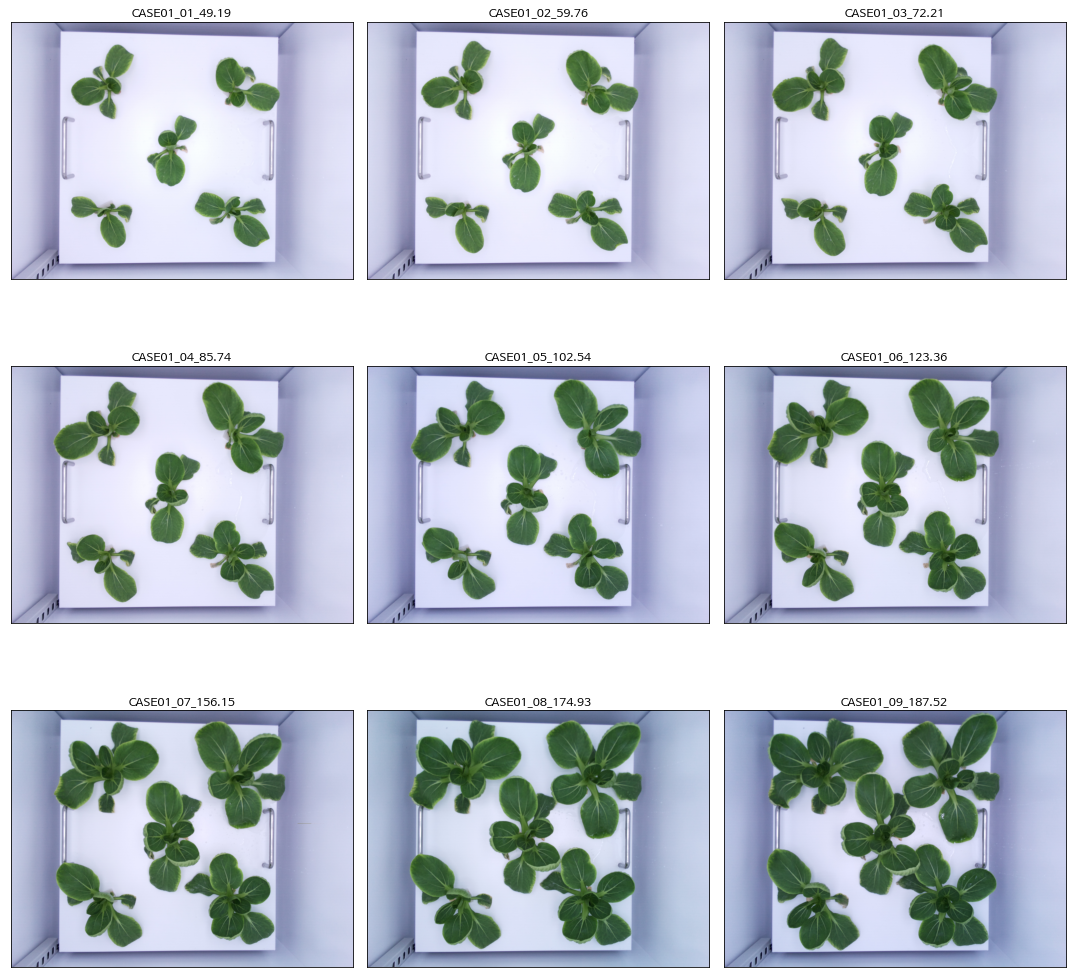

In [ ]:
rows, cols = ceil(nums/3), 3
fsize = (cols*5, rows*5)
fig, axes = plt.subplots(rows, cols, figsize=fsize)
for i, ax in zip(range(nums), axes.ravel()):
    image = img.imread(tmp.img_path[i], 0)
    ax.imshow(image)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(tmp.label[i])
fig.tight_layout()

- 채광 또는 명도가 좀 다르게 보여진다.
- 전체적인 구도, 카메라 각도, 줌의 크기는 일정하다.
- 그러나, test 이미지는 줌이 나타난다.

#### 3) 평균 메타의 시각화

In [ ]:
metacols = tmp.columns[9:]
metacols

Index(['내부온도관측치', '외부온도관측치', '내부습도관측치', '외부습도관측치', 'CO2관측치', 'EC관측치', '최근분무량',
       '화이트 LED동작강도', '레드 LED동작강도', '블루 LED동작강도', '냉방온도', '냉방부하', '난방온도',
       '난방부하', '총추정광량', '백색광추정광량', '적색광추정광량', '청색광추정광량'],
      dtype='object')

In [ ]:
tmp[metacols]

내부온도관측치    외부온도관측치    내부습도관측치   외부습도관측치      CO2관측치      EC관측치  최근분무량  \
0  22.236181  43.868542  77.740695  4.898172  487.226389  19.594792    0.0   
1  23.011319  44.573750  77.645972  4.687392  480.144444  20.855555    0.0   
2  22.931111  39.537708  77.514931  4.957483  489.068750  20.748611    0.0   
3  21.027986  58.497500  80.069930  4.006066  481.378472  18.195278    0.0   
4  21.874305  67.058819  81.349792  4.335634  490.568750  19.400486    0.0   
5  24.317304  49.946181  80.187431  4.584211  496.162500  23.126528    0.0   
6  24.452467  56.567686  81.520709  4.798408  512.528839  23.363377    0.0   
7  24.626180  61.916736  82.388611  5.082825  514.197917  23.617708    0.0   
8  25.368798  76.540375  83.486379  3.684119  493.246699  23.872342    0.0   

   화이트 LED동작강도  레드 LED동작강도  블루 LED동작강도       냉방온도        냉방부하       난방온도  \
0   200.710166  201.000000    0.233721  17.417129  179.488256  18.854662   
1   200.856836  200.856836    0.233993  17.414777  179.413149  18.852110   
2   200.711621  200.423851    0.233993  17.417408  179.554817  18.854995   
3   200.133285  200.278936    0.233721  17.416580  179.504056  18.854097   
4   200.855804  201.000000    0.233721  17.417364  179.523273  18.854948   
5   201.000000  200.855596    0.232908  17.414632  179.354673  18.851888   
6   200.712644  201.000000    0.233721  17.417384  179.616062  18.854982   
7   200.277898  200.565249    0.234266  17.417621  179.577126  18.855243   
8   200.567315  200.565437    0.233179  17.415972  179.405956  18.853424   

        난방부하       총추정광량    백색광추정광량    적색광추정광량  청색광추정광량  
0  10.227934  145.968975  12.396976  21.122305      NaN  
1  13.706011  145.929643  12.389964  21.093542      NaN  
2  13.347289  146.041083  12.375941  21.137793      NaN  
3   7.522328  146.006121  12.370097  21.127837      NaN  
4  10.943099  145.999566  12.396976  21.126731      NaN  
5  20.119310  145.920551  12.354361  21.079761      NaN  
6  20.794515  146.102266  12.377109  21.136687      NaN  
7  21.669855  146.047638  12.401651  21.127837      NaN  
8  25.372952  145.942754  12.361917  21.101286      NaN

9개의 이미지에 대한 메타데이터의 평균값을 시각화하면

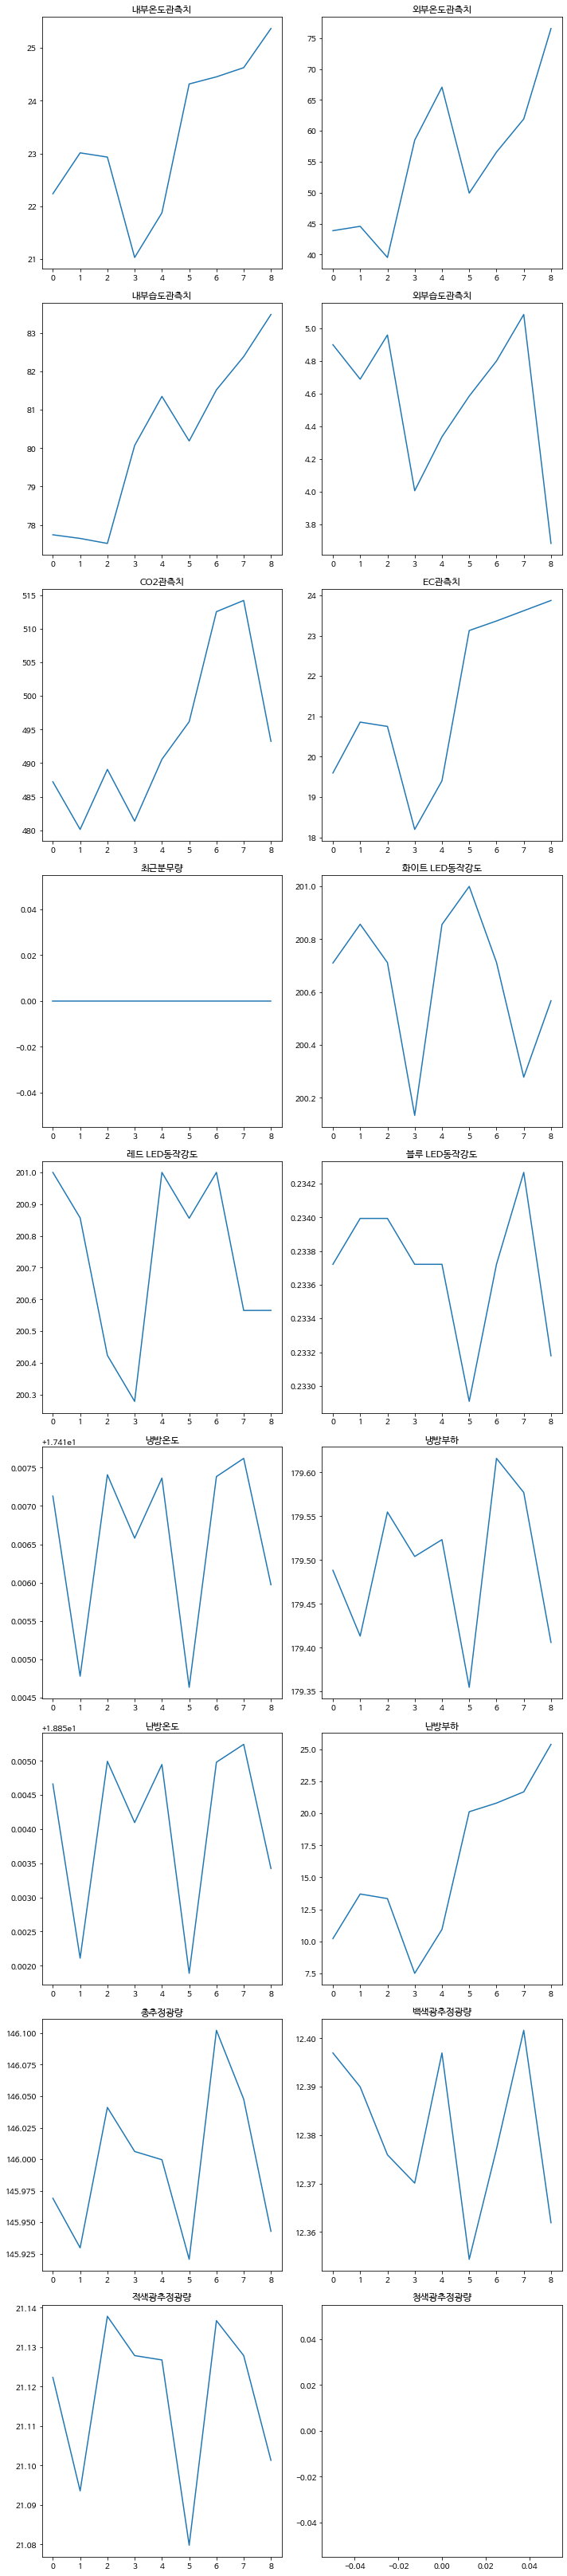

In [ ]:
rows, cols = ceil(len(metacols)/2), 2
fsize = (cols*5, rows*5)
fig, axes = plt.subplots(rows, cols, figsize=fsize)
for col, ax in zip(metacols, axes.ravel()):
    ax.plot(tmp[col])
    ax.set_title(col)
fig.tight_layout()

#### 4) 결측치의 수


In [ ]:
nas = []
for i in range(nums):
    nas.append(metas[i].isna().sum(0))

nas = pd.concat(nas, 1).T
nas

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  """


시간  내부온도관측치  외부온도관측치  내부습도관측치  외부습도관측치  CO2관측치  EC관측치  최근분무량  화이트 LED동작강도  \
0   0        0        0        0      291       0      0      0           53   
1   0        0        0        0      282       0      0      0           43   
2   0        0        0        0      264       0      0      0           46   
3   0        0        0        0      286       0      0      0           52   
4   0        0        0        0      281       0      0      0           53   
5   0        1        0        0      300       0      0      0           50   
6   0        1        1        1      309       1      1      0           48   
7   0        0        0        0      293       0      0      0           51   
8   0        1        1        1      294       1      1      0           51   

   레드 LED동작강도  블루 LED동작강도  냉방온도  냉방부하  난방온도  난방부하  총추정광량  백색광추정광량  적색광추정광량  \
0          51         580    24    24    24    24     24       24       24   
1          43         581    24    24    24    24     24       24       24   
2          48         581    24    24    24    24     24       24       24   
3          49         580    24    24    24    24     24       24       24   
4          51         580    24    24    24    24     24       24       24   
5          55         577    23    23    23    24     23       23       23   
6          51         580    24    24    24    24     24       24       24   
7          53         582    24    24    24    24     24       24       24   
8          57         578    24    24    24    24     24       24       24   

   청색광추정광량  
0     1440  
1     1440  
2     1440  
3     1440  
4     1440  
5     1440  
6     1440  
7     1440  
8     1440

결측치의 수가 대략적으로 유사하다. 결측치를 좀 더 상세히 보기 위해 6번 데이터를 출력해보자.

In [ ]:
metas[6]

시간    내부온도관측치    외부온도관측치    내부습도관측치  외부습도관측치  CO2관측치  \
0    2021-05-13 02:46:00  19.299999  65.599998  82.199997      0.0   653.0   
1    2021-05-13 02:47:00  19.299999  65.500000  82.099998      NaN   658.0   
2    2021-05-13 02:48:00  19.200001  65.599998  82.400002      0.0   652.0   
3    2021-05-13 02:49:00  19.200001  65.599998  82.300003      0.0   654.0   
4    2021-05-13 02:50:00  19.200001  65.599998  82.400002      0.0   654.0   
...                  ...        ...        ...        ...      ...     ...   
1435 2021-05-14 02:41:00  19.799999  65.199997  83.099998      0.0   658.0   
1436 2021-05-14 02:42:00  19.799999  65.300003  83.099998      0.0   654.0   
1437 2021-05-14 02:43:00  19.799999  65.500000  83.000000      0.0   655.0   
1438 2021-05-14 02:44:00  19.799999  65.800003  82.800003      0.0   656.0   
1439 2021-05-14 02:45:00  19.799999  66.099998  82.699997      0.0   655.0   

          EC관측치  최근분무량  화이트 LED동작강도  레드 LED동작강도  블루 LED동작강도  냉방온도  냉방부하  난방온도  \
0     19.400000    0.0        201.0       201.0       201.0  14.0   0.0  15.0   
1     19.400000    0.0        201.0       201.0         0.0  14.0   0.0  15.0   
2     19.400000    0.0        201.0       201.0         NaN  14.0   0.0  15.0   
3     19.299999    0.0        201.0       201.0         0.0  14.0   0.0  15.0   
4     19.299999    0.0        201.0       201.0         0.0  14.0   0.0  15.0   
...         ...    ...          ...         ...         ...   ...   ...   ...   
1435  19.900000    0.0        201.0         NaN         NaN  14.0   0.0  15.0   
1436  19.799999    0.0        201.0       201.0         0.0  14.0   0.0  15.0   
1437  19.700001    0.0        201.0       201.0         NaN  14.0   0.0  15.0   
1438  19.600000    0.0        201.0       201.0         0.0  14.0   0.0  15.0   
1439  19.900000    0.0        201.0       201.0         0.0  14.0   0.0  15.0   

           난방부하  총추정광량  백색광추정광량  적색광추정광량  청색광추정광량  
0     16.499996    0.0      0.0      0.0      NaN  
1     16.499996    0.0      0.0      0.0      NaN  
2     16.000004    0.0      0.0      0.0      NaN  
3     16.000004    0.0      0.0      0.0      NaN  
4     16.000004    0.0      0.0      0.0      NaN  
...         ...    ...      ...      ...      ...  
1435  18.999996    0.0      0.0      0.0      NaN  
1436  18.999996    0.0      0.0      0.0      NaN  
1437  18.999996    0.0      0.0      0.0      NaN  
1438  18.999996    0.0      0.0      0.0      NaN  
1439  18.999996    0.0      0.0      0.0      NaN  

[1440 rows x 19 columns]

metas의 데이터를 모두 합하여 이를 시각화해보자.

In [ ]:
import seaborn as sns
# ax = sns.lineplot(data=casemetas, x='시간', y='내부온도관측치', hue='numOfImg',
#                   palette=sns.color_palette("Paired", as_cmap=True))
# _ = plt.xticks(rotation=45)
# ax2 = ax.twinx()
# _ = sns.lineplot(data=casemetas, x='시간', y='leaf_weight', hue='numOfImg',
#                   palette=sns.color_palette("Paired", as_cmap=True), legend=False)

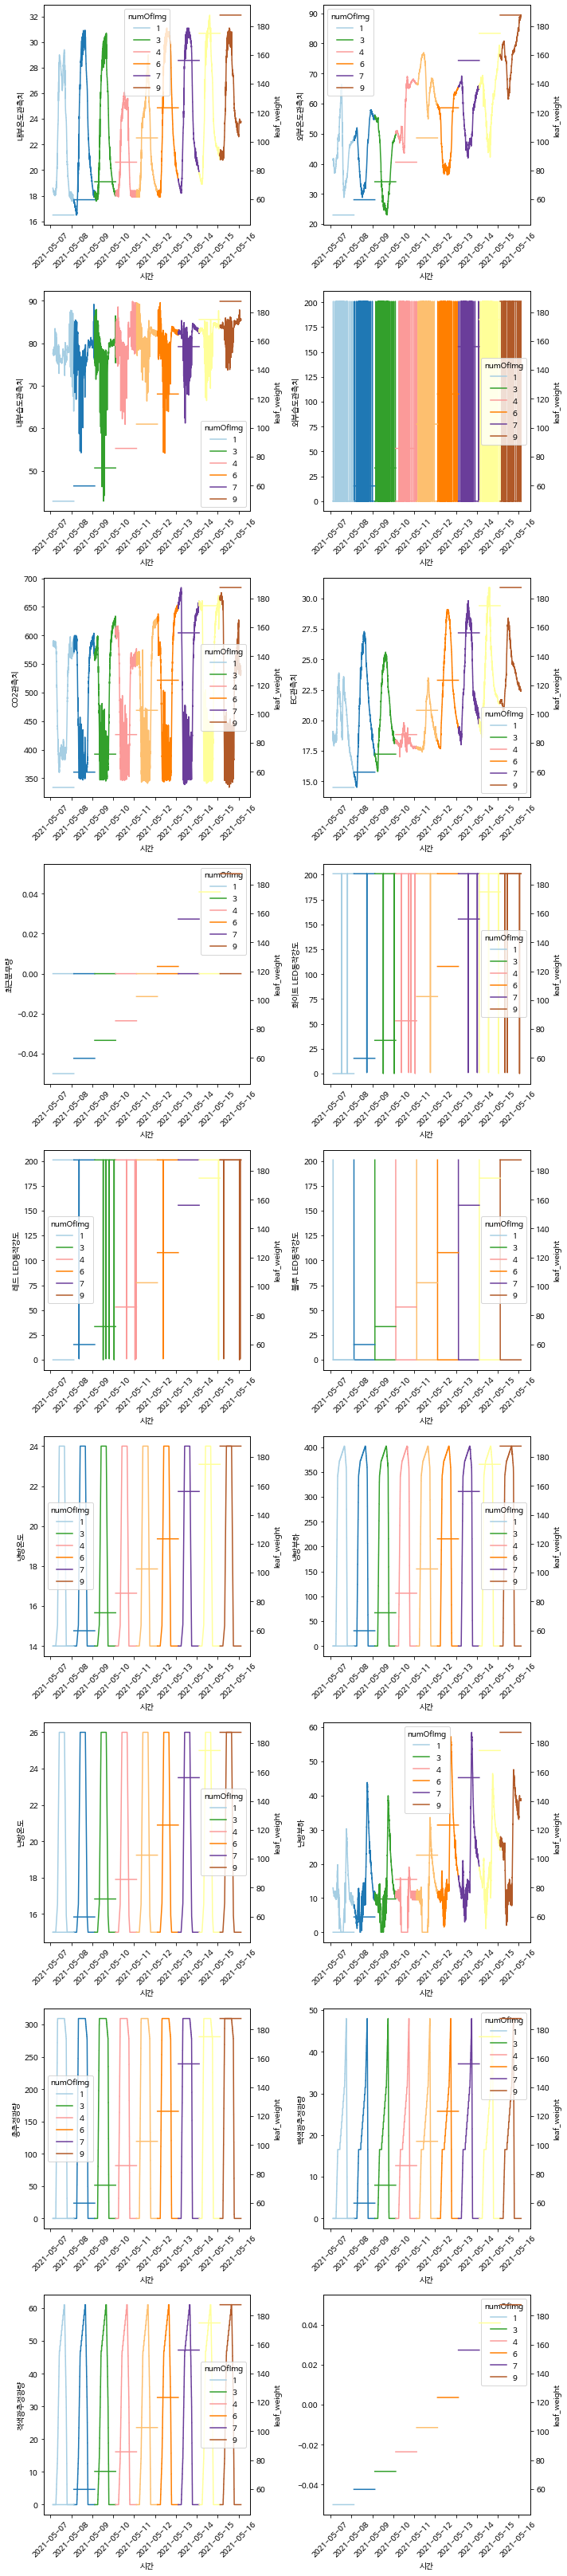

In [ ]:
casemetas = pd.concat(metas, axis=0, ignore_index=True)
numcase = len(metas)
casemetas['numOfImg'] = reduce(lambda x, y: x+y, [[i+1]*1440 for i in range(numcase)])
casemetas['leaf_weight'] = reduce(lambda x, y: x+y, [[tmp.leaf_weight[i]]*1440 for i in range(numcase)])

rows, cols = ceil(len(metacols)/2), 2
fsize = (cols*5, rows*5)
fig, axes = plt.subplots(rows, cols, figsize=fsize)
pal = sns.color_palette("Paired", as_cmap=True)
for col, ax in zip(metacols, axes.ravel()):
    sns.lineplot(data=casemetas, x='시간', y=col, hue='numOfImg',
                 palette=pal, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
    ax2 = ax.twinx()
    _ = sns.lineplot(data=casemetas, x='시간', y='leaf_weight', hue='numOfImg',
                     palette=pal, legend=False)
fig.tight_layout()

- 증가추세: 내부온도, 외부온도, 내부습도, CO2, EC, 난방부하
- 믿을 수 없음: 외부습도, 분무량, LED 강도, 블루광 추정량
- 주기적: 냉난방 온도/ 부하, 광 추정량

이제 이상의 작업을 함수화하여 case별로 결과를 보도록 하겠습니다.

In [ ]:
cases = train.case.unique()
cases

array(['CASE01', 'CASE02', 'CASE03', 'CASE04', 'CASE05', 'CASE06',
       'CASE07', 'CASE08', 'CASE09', 'CASE10', 'CASE11', 'CASE12',
       'CASE13', 'CASE14', 'CASE15', 'CASE16', 'CASE17', 'CASE18',
       'CASE19', 'CASE20', 'CASE21', 'CASE22', 'CASE23', 'CASE24',
       'CASE25', 'CASE26', 'CASE27', 'CASE28', 'CASE29', 'CASE30',
       'CASE31', 'CASE32', 'CASE33', 'CASE34', 'CASE35', 'CASE36',
       'CASE37', 'CASE38', 'CASE39', 'CASE40', 'CASE41', 'CASE42',
       'CASE43', 'CASE44', 'CASE45', 'CASE46', 'CASE47', 'CASE48',
       'CASE49', 'CASE50', 'CASE51', 'CASE52', 'CASE53', 'CASE54',
       'CASE55', 'CASE56', 'CASE57', 'CASE58', 'CASE59', 'CASE60',
       'CASE61', 'CASE62', 'CASE63', 'CASE64', 'CASE65', 'CASE66',
       'CASE67', 'CASE68', 'CASE69', 'CASE70', 'CASE71', 'CASE72',
       'CASE73', 'CASE74', 'CASE75'], dtype=object)

In [ ]:
from IPython.display import display
def createCaseTrain(case):
    # case = 'CASE01'
    tmp = train[train["case"] == case].reset_index(drop=True)
    tmp['label'] = tmp.img_name.str[:9] + '_' + tmp.leaf_weight.map(lambda x: str(round(x, 2)))
    nums = len(tmp)
    metas, stime, means = [], [], []
    for i in range(nums):
        metas.append(pd.read_csv(tmp.meta_path[i], parse_dates=['시간']))
        stime.append(metas[i]['시간'][0])
        means.append(metas[i].mean(0))

    tmp['stime'] = stime
    tmp['ddelta'] = (tmp['stime'] - tmp['stime'].shift(1)).dt.days
    sizes = [np.nan]*nums
    for i in range(nums):
        lag = tmp['ddelta'][i]
        if pd.notna(lag):
            sizes[i] = tmp.leaf_weight[i-int(lag)]
    tmp['size'] = sizes
    display(tmp[['size', 'leaf_weight']])
    tmp = pd.concat([tmp, pd.concat(means, axis=1).T], 1)
    return tmp, metas

In [ ]:
tmp6, metas6 = createCaseTrain(cases[5])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  # This is added back by InteractiveShellApp.init_path()


size  leaf_weight
0      NaN        0.118
1    0.118        0.500
2    0.500        0.971
3    0.971        1.371
4    1.371        1.395
5    1.395        1.956
6    1.956        2.283
7    2.283        4.698
8    4.698        7.327
9    7.327       10.241
10  10.241       15.189

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


In [ ]:
def caseImshow(tmp):
    nums = len(tmp)

    # 이미지 보기
    rows, cols = ceil(nums/3), 3
    fsize = (cols*5, rows*5)
    fig, axes = plt.subplots(rows, cols, figsize=fsize)
    for i, ax in zip(range(nums), axes.ravel()):
        image = img.imread(tmp.img_path[i], 0)
        ax.imshow(image)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(tmp.label[i])
    fig.tight_layout()

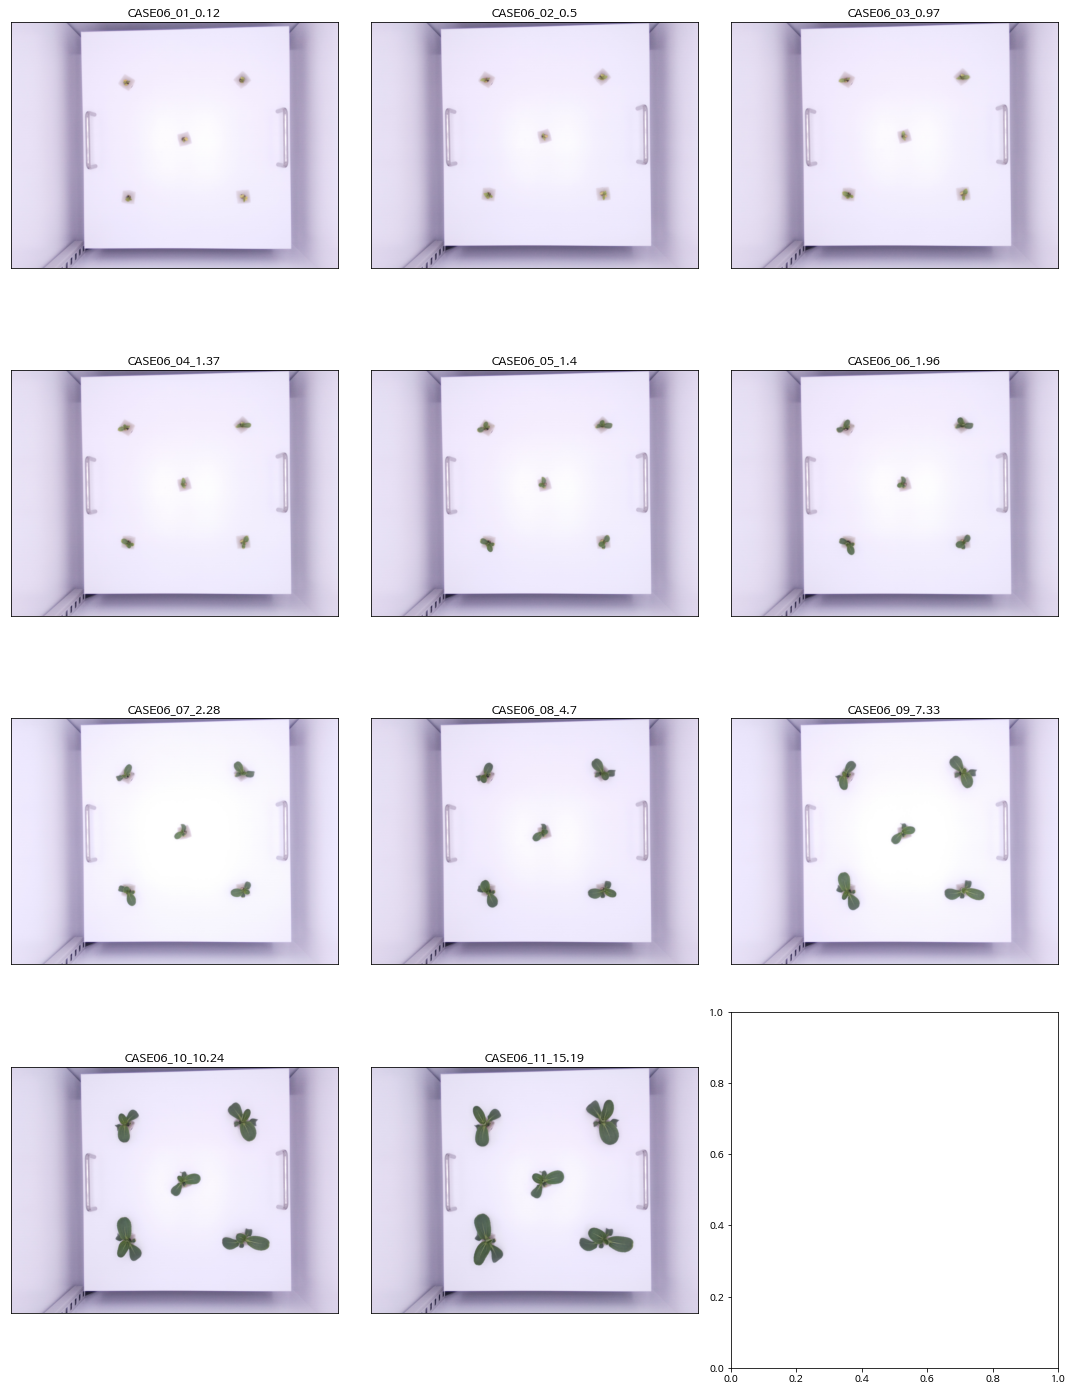

In [ ]:
caseImshow(tmp6)

In [ ]:
def printMetaNa(metas):
    nums = len(metas)
    if nums < 2:
        display(metas[0].isna().sum(0))
    else:
        nas = []
        for i in range(nums):
            nas.append(metas[i].isna().sum(0))
        nas = pd.concat(nas, axis=1).T
        display(nas)

In [ ]:
printMetaNa(metas6)

시간  내부온도관측치  외부온도관측치  내부습도관측치  외부습도관측치  CO2관측치  EC관측치  최근분무량  화이트 LED동작강도  \
0    0      605        3      581       20       0    957      0            0   
1    0      620        0      674        0       0    736      0            0   
2    0      886        0      911        0       0    930      0            0   
3    0      521        0      580       12       0    900      0            0   
4    0      491        0      493        0       0    915      0            0   
5    0      517        0      554        0       0    929      0            0   
6    0      517        0      577        0       0    890      0            0   
7    0      502        0      619        0       0    966      0            0   
8    0      541        0      629        0       0    878      0            0   
9    0      562        0      561        0       0    851      0            0   
10   0      504        0      579        0       0    970      0            0   

    레드 LED동작강도  블루 LED동작강도  냉방온도  냉방부하  난방온도  난방부하  총추정광량  백색광추정광량  적색광추정광량  \
0            0           0    24   665    24   665     24       24       24   
1            0           0    23   669    23   669     23       23       23   
2            0           0    24   937    24   937     24       24       24   
3            0           0    25   575    25   575     25       25       25   
4            0           0    25   535    25   535     25       25       25   
5            0           0    23   559    23   559     23       23       23   
6            0           0    24   576    24   576     24       24       24   
7            0           0    24   592    24   592     24       24       24   
8            0           0    23   589    23   589     23       23       23   
9            0           0    25   599    25   599     25       25       25   
10           0           0    25   588    25   588     25       25       25   

    청색광추정광량  
0        24  
1        23  
2        24  
3        25  
4        25  
5        23  
6        24  
7        24  
8        23  
9        25  
10       25

In [ ]:
def printMeanMetaCols(tmp):
    metacols = tmp.columns[9:]
    rows, cols = ceil(len(metacols)/2), 2
    fsize = (cols*5, rows*5)
    fig, axes = plt.subplots(rows, cols, figsize=fsize)
    for col, ax in zip(metacols, axes.ravel()):
        ax.plot(tmp[col])
        ax.set_title(col)
    fig.tight_layout()

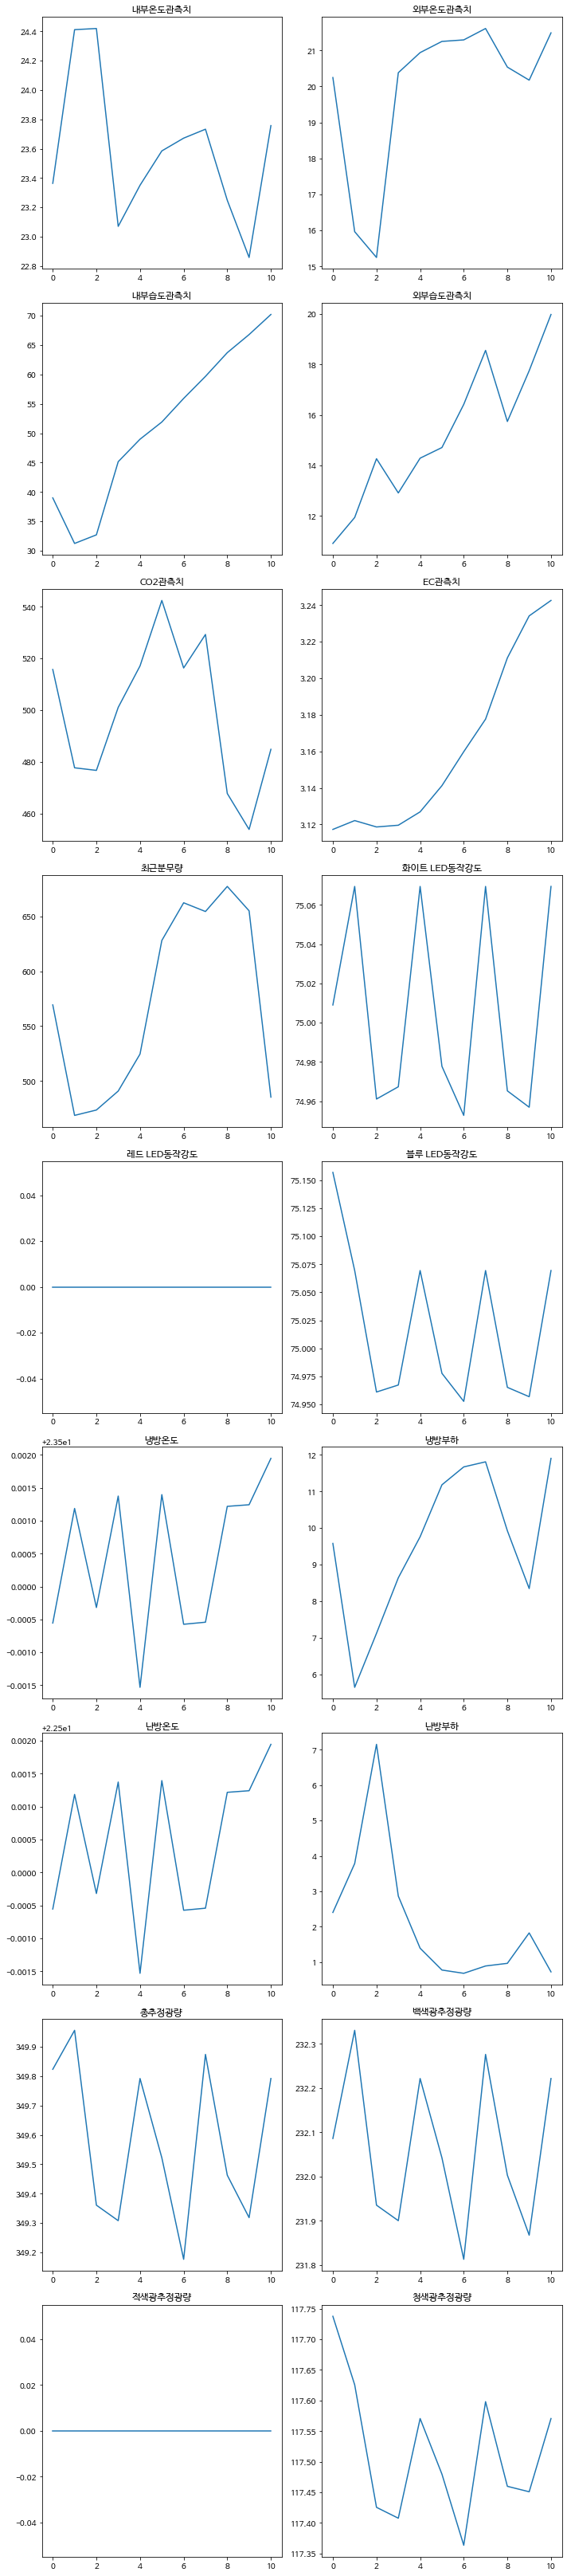

In [ ]:
printMeanMetaCols(tmp6)

- 총추정광량이 모든 광량을 합한 것과 같은 값을 가지는 것으로 보인다.

In [ ]:
tmp6.iloc[:, 9:]

내부온도관측치    외부온도관측치    내부습도관측치    외부습도관측치      CO2관측치     EC관측치  \
0   23.363342  20.246896  38.998687  10.910389  515.728472  3.117322   
1   24.411929  15.964931  31.239352  11.938611  477.716667  3.122155   
2   24.419793  15.248292  32.702333  14.265972  476.714583  3.118672   
3   23.069816  20.380805  45.157895  12.910596  501.078472  3.119614   
4   23.350269  20.939403  48.986791  14.287540  517.107639  3.126933   
5   23.584619  21.250375  51.914715  14.708646  542.421528  3.141262   
6   23.671713  21.292417  55.928836  16.417292  516.319444  3.159836   
7   23.732731  21.608972  59.683956  18.556379  529.272222  3.177643   
8   23.248066  20.536736  63.720470  15.740458  467.783333  3.211146   
9   22.857531  20.174319  66.800834  17.751153  453.888889  3.234133   
10  23.757197  21.488417  70.221587  19.978500  484.864236  3.242569   

         최근분무량  화이트 LED동작강도  레드 LED동작강도  블루 LED동작강도       냉방온도       냉방부하  \
0   569.361861    75.009028         0.0   75.156944  23.499445   9.579585   
1   468.778681    75.069444         0.0   75.069444  23.501185   5.641066   
2   473.671306    74.961111         0.0   74.961111  23.499681   7.118641   
3   490.928285    74.967361         0.0   74.967361  23.501373   8.638992   
4   524.617486    75.069444         0.0   75.069444  23.498469   9.761832   
5   628.008194    74.977778         0.0   74.977778  23.501395  11.183280   
6   662.291278    74.952778         0.0   74.952778  23.499427  11.673125   
7   654.355160    75.069444         0.0   75.069444  23.499458  11.812617   
8   677.180340    74.965278         0.0   74.965278  23.501217   9.926351   
9   654.988396    74.956944         0.0   74.956944  23.501241   8.344059   
10  485.394347    75.069444         0.0   75.069444  23.501946  11.906923   

         난방온도      난방부하       총추정광량     백색광추정광량  적색광추정광량     청색광추정광량  
0   22.499445  2.400357  349.823427  232.085906      0.0  117.737520  
1   22.501185  3.783869  349.956133  232.330445      0.0  117.625688  
2   22.499681  7.154782  349.360682  231.935134      0.0  117.425548  
3   22.501373  2.863707  349.307853  231.900062      0.0  117.407791  
4   22.498469  1.388534  349.792028  232.221498      0.0  117.570530  
5   22.501395  0.772122  349.521977  232.042215      0.0  117.479761  
6   22.499427  0.679195  349.176365  231.812769      0.0  117.363596  
7   22.499458  0.886572  349.874138  232.276010      0.0  117.598129  
8   22.501217  0.961588  349.462773  232.002911      0.0  117.459862  
9   22.501241  1.822159  349.318229  231.867262      0.0  117.450967  
10  22.501946  0.719800  349.792028  232.221498      0.0  117.570530

In [ ]:
tmp6.iloc[:, -4] - tmp6.iloc[:, -3:].sum(axis=1)

0     2.614797e-12
1     2.842171e-12
2     2.842171e-12
3     2.728484e-12
4     2.785328e-12
5     2.785328e-12
6     2.842171e-12
7     2.842171e-12
8     2.785328e-12
9     2.728484e-12
10    2.785328e-12
dtype: float64

In [ ]:
def displayMetas(casemetas, isMany=True):
    metacols = casemetas.columns[1:-2]
    rows, cols = ceil(len(metacols)/2), 2
    fsize = (cols*5, rows*5)
    fig, axes = plt.subplots(rows, cols, figsize=fsize)
    if isMany:
        pal = sns.color_palette("Paired", as_cmap=True)
        for col, ax in zip(metacols, axes.ravel()):
            sns.lineplot(data=casemetas, x='시간', y=col, hue='numOfImg',
                        palette=pal, ax=ax)
            ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
            ax2 = ax.twinx()
            _ = sns.lineplot(data=casemetas, x='시간', y='leaf_weight', hue='numOfImg',
                            palette=pal, legend=False)
    else:
        for col, ax in zip(metacols, axes.ravel()):
            sns.lineplot(data=casemetas, x='시간', y=col, ax=ax)
            ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
            ax2 = ax.twinx()
            _ = sns.lineplot(data=casemetas, x='시간', y='leaf_weight', legend=False)
    fig.tight_layout()

In [ ]:
# displayMetas(casemetas)

In [ ]:
def caseEda(case):
    tmp, metas = createCaseTrain(case)
    numcase = len(tmp)

    # 이미지 보기
    caseImshow(tmp)

    # 메타의 결측치의 수
    printMetaNa(metas)

    # meta 평균 시각화
    if numcase > 1:
        printMeanMetaCols(tmp)

    # 메타의 모든 데이터를 시각화
    casemetas = pd.concat(metas, axis=0, ignore_index=True)
    casemetas['numOfImg'] = reduce(lambda x, y: x+y, [[i+1]*1440 for i in range(numcase)])
    casemetas['leaf_weight'] = reduce(lambda x, y: x+y, [[tmp.leaf_weight[i]]*1440 for i in range(numcase)])
    displayMetas(casemetas, numcase>1)

    return tmp, casemetas

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  # This is added back by InteractiveShellApp.init_path()


size  leaf_weight
0   NaN      298.036

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


시간               0
내부온도관측치          0
외부온도관측치          0
내부습도관측치          0
외부습도관측치          0
CO2관측치           0
EC관측치            0
최근분무량            0
화이트 LED동작강도     93
레드 LED동작강도     105
블루 LED동작강도     121
냉방온도            25
냉방부하            25
난방온도            25
난방부하            25
총추정광량           25
백색광추정광량         25
적색광추정광량         25
청색광추정광량         25
dtype: int64

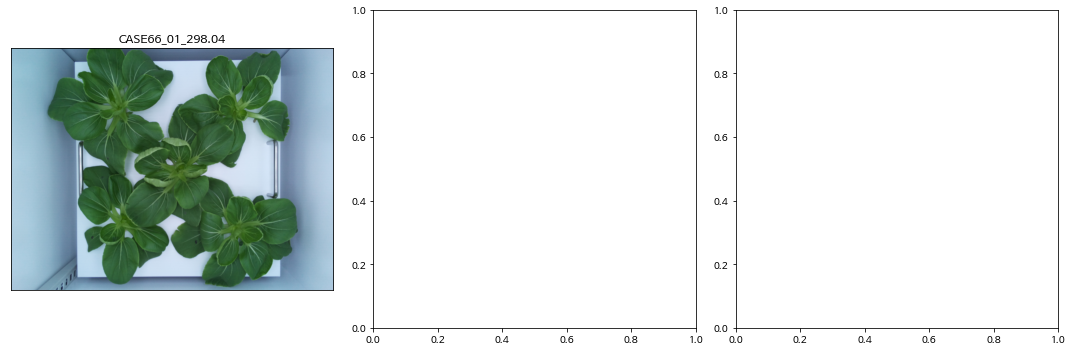

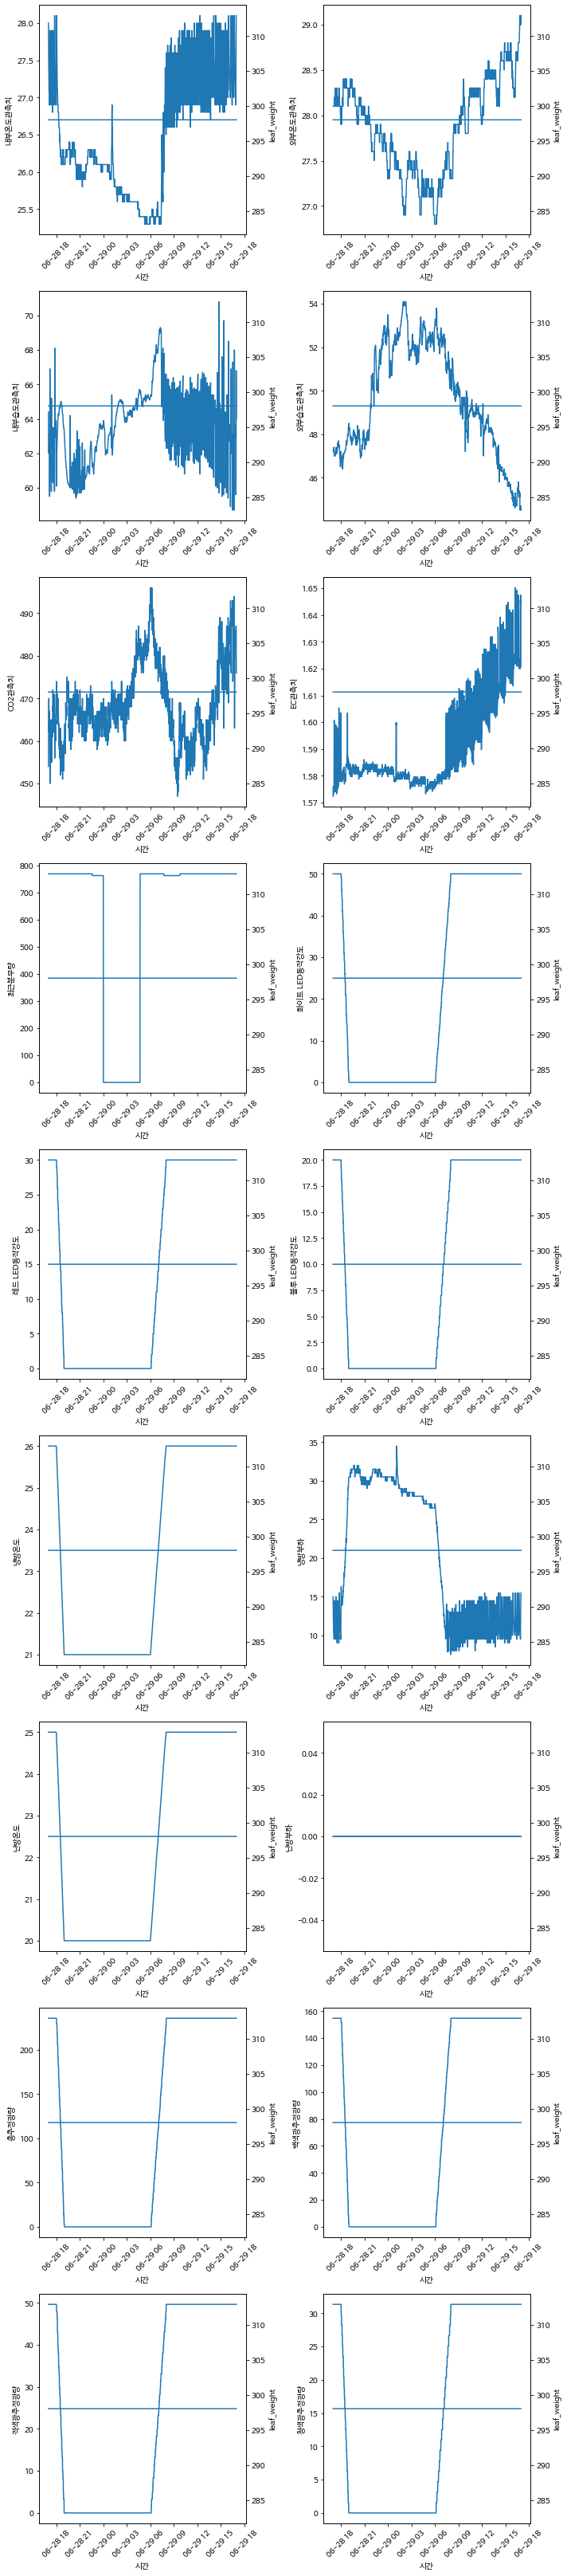

In [ ]:
_ = caseEda(cases[65])

이제 랜덤하게 몇개의 case들을 들여다보자.

In [ ]:
from random import randint

In [ ]:
caseEda(cases[randint(0, len(cases)-1)])

Output hidden; open in https://colab.research.google.com to view.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  # This is added back by InteractiveShellApp.init_path()


size  leaf_weight
0      NaN        0.668
1    0.668        1.031
2    1.031        1.373
3    1.373        1.627
4    1.627        1.481
5    1.481        2.127
6    2.127        3.158
7    3.158        4.222
8    4.222        6.223
9    6.223       10.218
10  10.218       14.736

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


시간  내부온도관측치  외부온도관측치  내부습도관측치  외부습도관측치  CO2관측치  EC관측치  최근분무량  화이트 LED동작강도  \
0    0      671        9      602       12       0      0      0            0   
1    0     1036        0     1006        0       0      0      0            0   
2    0      558        0      587        0       0      0      0            0   
3    0      605        0      606        0       0      0      0            0   
4    0      481        0      474        0       0      0      0            0   
5    0      467        0      433        0       0      0      0            0   
6    0      472        0      499        0       0      0      0            0   
7    0      452        0      435        0       0      0      0            0   
8    0      475        0      457        0       0      0      0            0   
9    0      529        0      530        0       0      0      0            0   
10   0      489        0      481        0       0      0      0            0   

    레드 LED동작강도  블루 LED동작강도  냉방온도  냉방부하  난방온도  난방부하  총추정광량  백색광추정광량  적색광추정광량  \
0            0           0    24   755    24   755     24       24       24   
1            0           0    23  1087    23  1087     23       23       23   
2            0           0    24   597    24   597     24       24       24   
3            0           0    24   684    24   684     24       24       24   
4            0           0    24   540    24   540     24       24       24   
5            0           0    23   527    23   527     23       23       23   
6            0           0    24   519    24   519     24       24       24   
7            0           0    24   514    24   514     24       24       24   
8            0           0    24   551    24   551     24       24       24   
9            0           0    24   636    24   636     24       24       24   
10           0           0    24   539    24   539     24       24       24   

    청색광추정광량  
0        24  
1        23  
2        24  
3        24  
4        24  
5        23  
6        24  
7        24  
8        24  
9        24  
10       24

(         img_name  leaf_weight                                    img_path  \
 0   CASE18_01.jpg        0.668  ./dataset/train/CASE18/image/CASE18_01.jpg   
 1   CASE18_02.jpg        1.031  ./dataset/train/CASE18/image/CASE18_02.jpg   
 2   CASE18_03.jpg        1.373  ./dataset/train/CASE18/image/CASE18_03.jpg   
 3   CASE18_04.jpg        1.627  ./dataset/train/CASE18/image/CASE18_04.jpg   
 4   CASE18_05.jpg        1.481  ./dataset/train/CASE18/image/CASE18_05.jpg   
 5   CASE18_06.jpg        2.127  ./dataset/train/CASE18/image/CASE18_06.jpg   
 6   CASE18_07.jpg        3.158  ./dataset/train/CASE18/image/CASE18_07.jpg   
 7   CASE18_08.jpg        4.222  ./dataset/train/CASE18/image/CASE18_08.jpg   
 8   CASE18_09.jpg        6.223  ./dataset/train/CASE18/image/CASE18_09.jpg   
 9   CASE18_10.jpg       10.218  ./dataset/train/CASE18/image/CASE18_10.jpg   
 10  CASE18_11.jpg       14.736  ./dataset/train/CASE18/image/CASE18_11.jpg   
 
                                     meta_path    

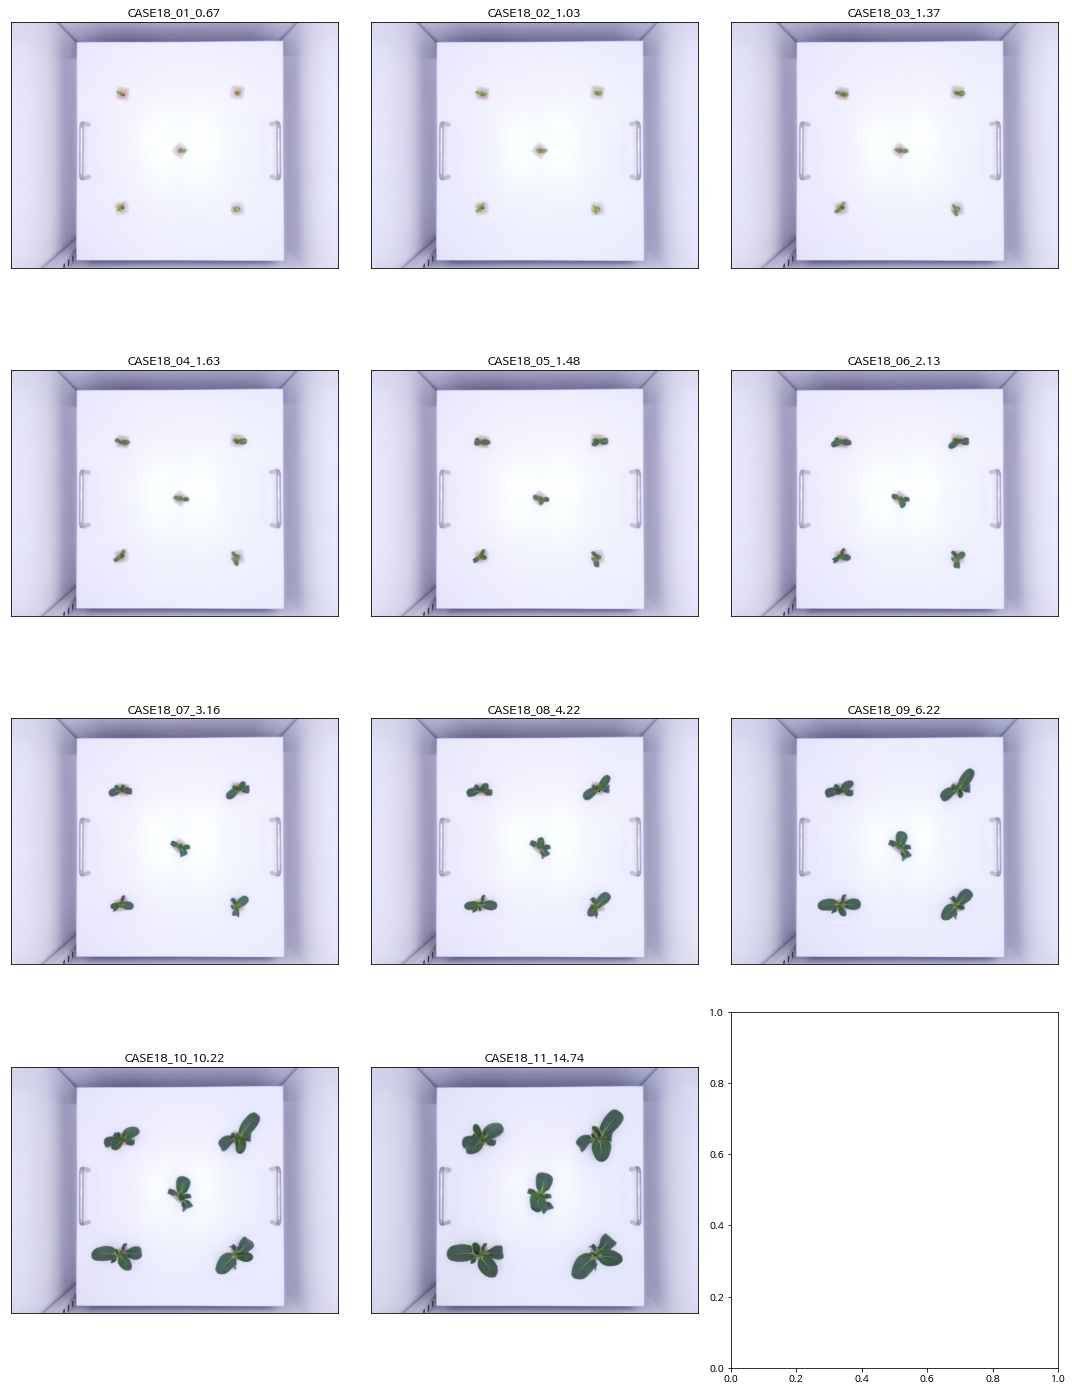

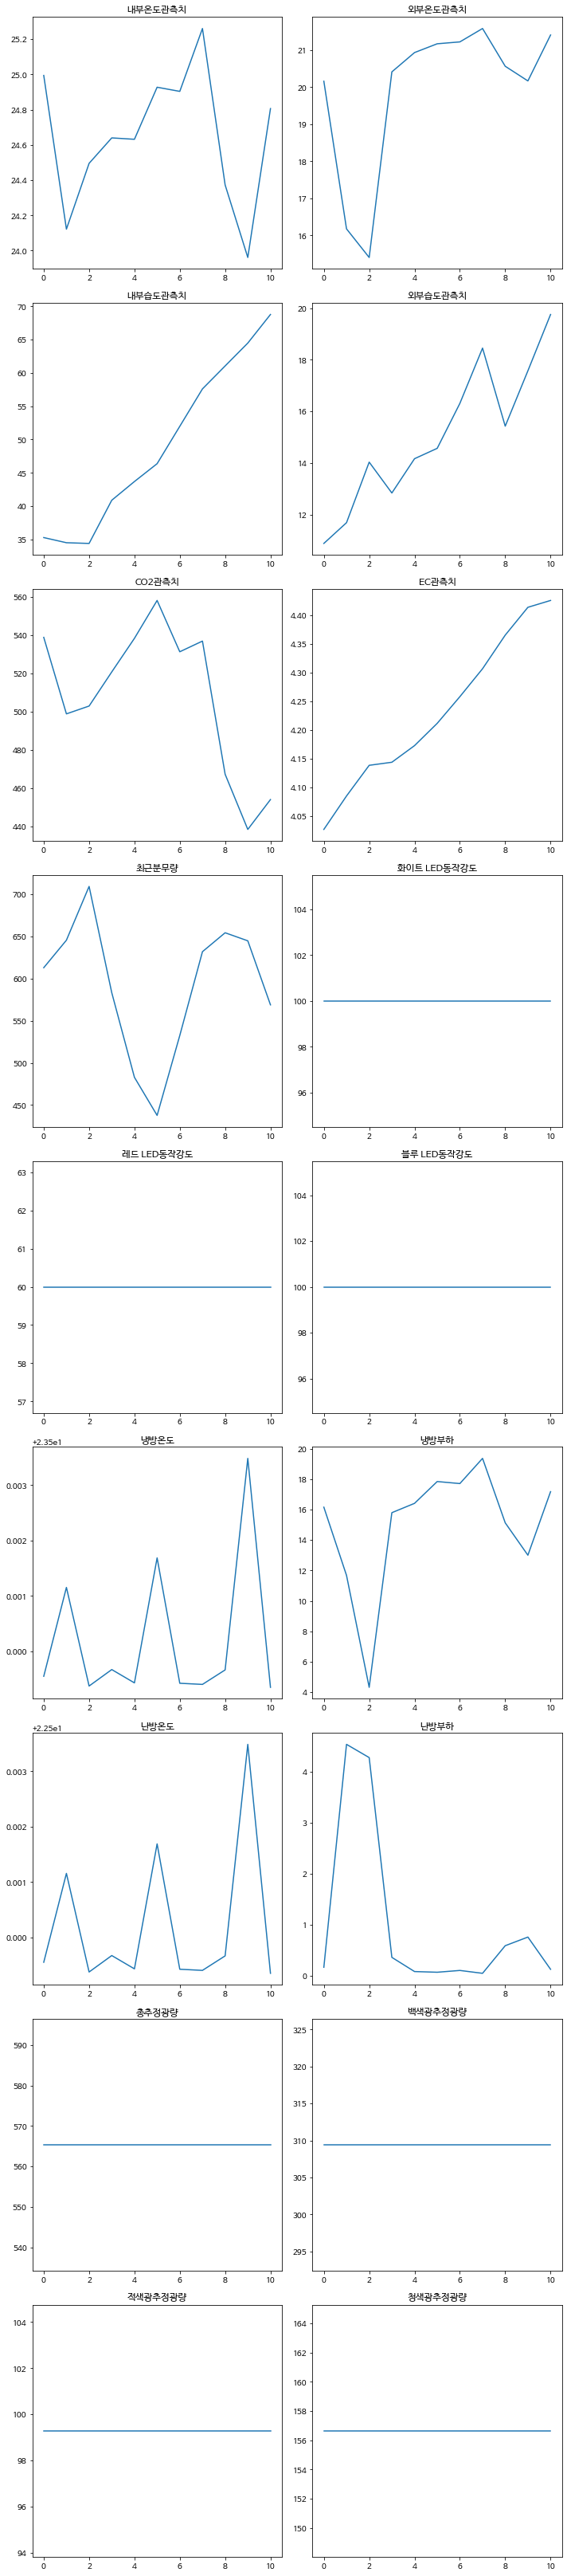

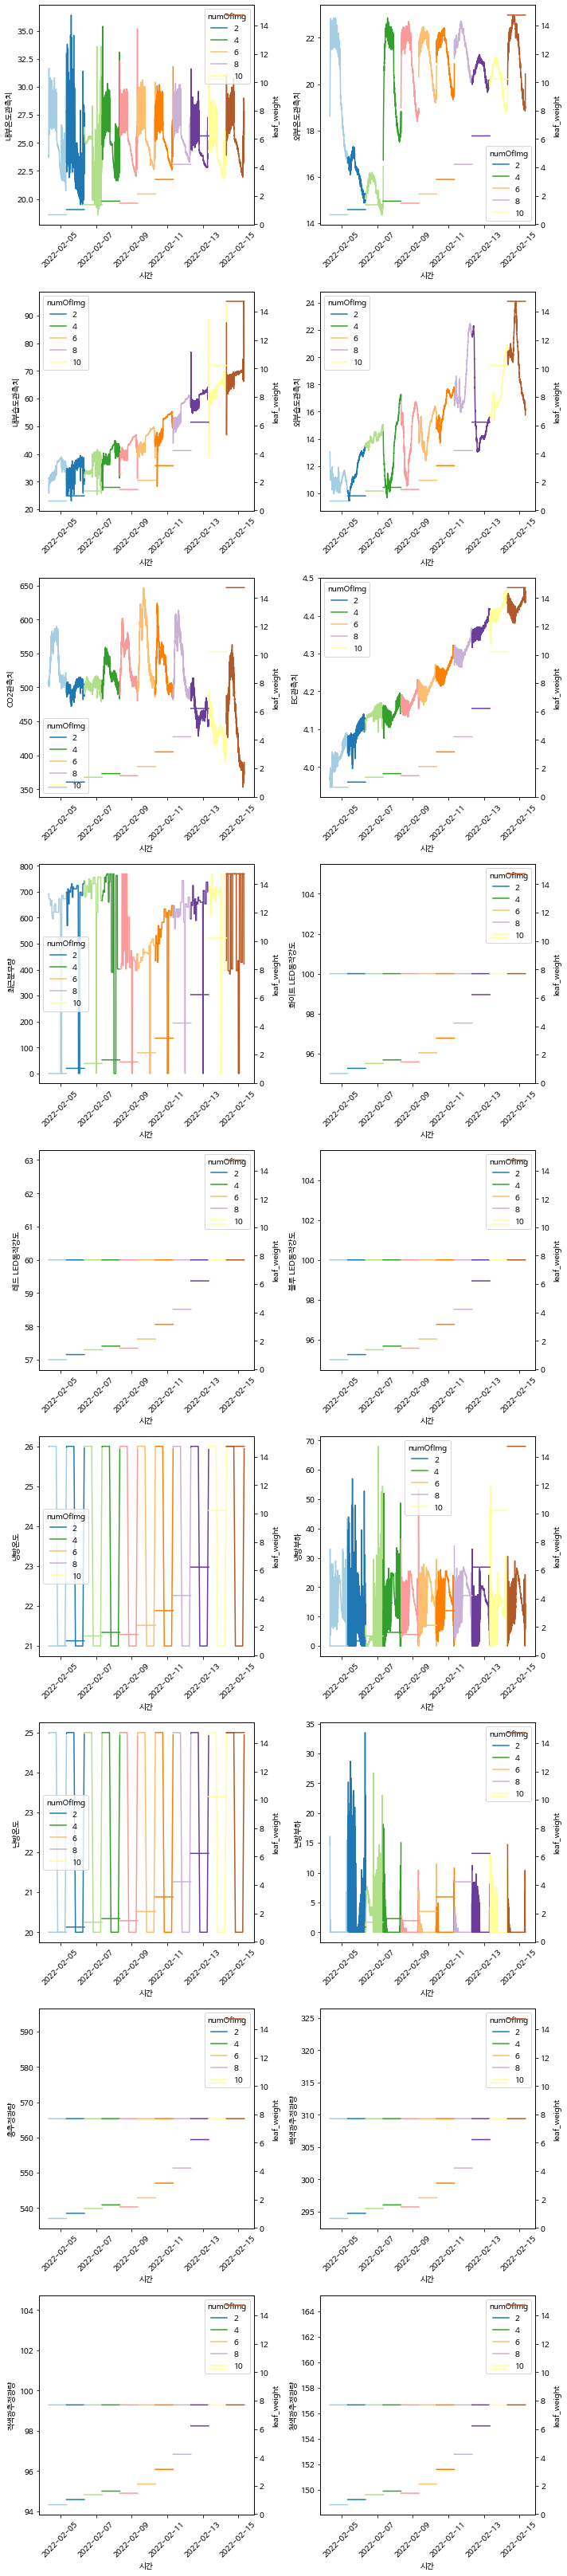

In [ ]:
caseEda(cases[randint(0, len(cases)-1)])

1. case 59는 
 - 색감이 매우 다양(붉은 -> 청색)
 - 메타는 모두 결측치
 - 마지막 2개에서는 청경채가 작아지고 있음
 - 청경채의 크기는 키가 큰 S(적분기호) 곡선을 그림
2. case28에서는 
 - 씨앗은 아니고 작은 잎에서 출발하여 점점 커짐
 - 잎무게가 5이상일 때 내부습도를 60이상에서 80까지 점점 늘림
 - CO2 관측치의 변동이 커지면서 점점 평균이 높아지고
 - EC는 0.1 이하의 낮은 값에서 무게가 0.45 즈음에 1.0~1.2의 높은 값을 유지
 - 분무량은 400 ~ 800 정도를 유지하고

### 1.4 이미지에서 판넬 추출하기
이미지에서 바탁 판넬을 추출하여, 판넬의 넓이를 구하면:
1. 이미지 대비 청경채의 면적율을 구하고
2. 면적률을 알아 볼 수 없는 이미지에 대해 면적율을 예측하는 모델을 만들고
 - train과 test에서 적당히 확인
3. 면적률에 대한 2차 다항 회귀로 
 - 현 이미지의 청경채 무게를 계산하는 모델을 구성
 - 메타와 함께 1일 이후의 청경재 무게를 계산하는 모델을 구성

#### 1) 컬러이미지로 부터
3개 포인트가 구성하는 각도의 cos 절대값를 계산하는 함수를 정의하고

In [ ]:
import cv2

# cos absolute value of the angle between p0 to p1 to p3
def angle_cos(p0, p1, p2):
    d1, d2 = (p0-p1).astype('float'), (p2-p1).astype('float')
    return abs( np.dot(d1, d2) / np.sqrt( np.dot(d1, d1)*np.dot(d2, d2) ) )

In [ ]:
-0.1 % 3.14, 0.1 % 3.14
theta = 1.5
(theta % 3.14) > (3.14/4) # vertical

True

컬러 이미지의 BGR 채널 각각에서 코너를 검출하는 함수를 정의합니다.

In [ ]:
def find_squares(img):
    img = cv2.GaussianBlur(img, (5, 5), 0)
    squares = []
    for gray in cv2.split(img):
        for thrs in range(0, 255, 26):
            if thrs == 0:
                bin = cv2.Canny(gray, 0, 50, apertureSize=5)
                bin = cv2.dilate(bin, None)
            else:
                _retval, bin = cv2.threshold(gray, thrs, 255, cv2.THRESH_BINARY)
            contours, _hierarchy = cv2.findContours(bin, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
            for cnt in contours:
                cnt_len = cv2.arcLength(cnt, True)
                # contour까지의 최대 거리인 0.02*cnt_len을 늘리면 더 근사값을 구할 수 있다.
                cnt = cv2.approxPolyDP(cnt, 0.02*cnt_len, True)
                # 사각형을 찾고 면적이 1000보다 크고(해상도에 따라 조절), 볼록한 것이면
                if len(cnt) == 4 and cv2.contourArea(cnt) > 1000 and cv2.isContourConvex(cnt):
                    cnt = cnt.reshape(-1, 2)
                    # 우리의 경우 min_cos도 고려해볼 만함.
                    max_cos = np.max([angle_cos( cnt[i], cnt[(i+1) % 4], cnt[(i+2) % 4] ) for i in range(4)])
                    # cnt는 좌상단에서 시계방향으로 : (xl, yt) (xr, yt) (xr, yb) (xl, yb)
                    a = (cnt[1][1] - cnt[0][1])

                    # 각도가 90도 근방이고, 대각선 모양의 직사각 형식이 아니면
                    if max_cos < 0.1 and a < img.shape[0]*0.8:
                        squares.append(cnt)
    return squares

이제 이미지에 검출한 사각형 코너 후보들로 부터 박스를 그려넣으면:

In [ ]:
from google.colab.patches import cv2_imshow

boxes = []
maxnum = len(train)
imgIdx = np.random.randint(0, maxnum, 12)
for imgPath in train.img_path[imgIdx]:
    img = cv2.imread(imgPath)
    squares = find_squares(img)
    boxes.append(squares)
    cv2.drawContours(img, squares, -1, (0, 255, 0), 3)
    # cv2.imshow('squares', img)
    cv2_imshow(img)
    cv2.waitKey(0)
cv2.destroyAllWindows()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
train.img_path[201].split('/')[-1].split('.')[0]

'CASE12_04'

In [ ]:
for box in boxes:
    print(box)

In [ ]:
for box in boxes:
    if len(box)>0:
        print(len(box))
    else:
        print(box)

8
3
3
3
[]
3
2
3
2
4
2
[]


이제 가장 큰 박스를 후보 박스로 결정하고, 그 면적을 계산합니다.

In [ ]:
newboxes, maxareas = [], []
for idx, boxs in zip(imgIdx, boxes):
    numbox = len(boxs)
    print(f"{train.img_path[idx].split('/')[-1].split('.')[0]}에서 발견된 box의 수는 {numbox}이고,")
    marea, maxbox = 0, None
    newbox = []
    if numbox == 0:
        newboxes.append(newbox)
        maxareas.append(marea)
    else:
        for b in boxs:
            area = cv2.contourArea(b)
            if area > marea:
                maxbox = b
                marea = area

        newboxes.append([maxbox])
        maxareas.append(marea)

print(newboxes)
print(maxareas)

CASE12_04에서 발견된 box의 수는 8이고,
CASE11_29에서 발견된 box의 수는 3이고,
CASE68_21에서 발견된 box의 수는 3이고,
CASE34_06에서 발견된 box의 수는 3이고,
CASE26_29에서 발견된 box의 수는 0이고,
CASE56_18에서 발견된 box의 수는 3이고,
CASE60_06에서 발견된 box의 수는 2이고,
CASE32_13에서 발견된 box의 수는 3이고,
CASE10_37에서 발견된 box의 수는 2이고,
CASE42_02에서 발견된 box의 수는 4이고,
CASE11_31에서 발견된 box의 수는 2이고,
CASE61_28에서 발견된 box의 수는 0이고,
[[array([[ 538,  142],
       [2607,  163],
       [2592, 2321],
       [ 542, 2332]], dtype=int32)], [array([[ 551,   56],
       [2618,   82],
       [2603, 2246],
       [ 541, 2256]], dtype=int32)], [array([[ 639,  152],
       [2713,  222],
       [2638, 2401],
       [ 575, 2349]], dtype=int32)], [array([[ 573,  105],
       [2660,  156],
       [2605, 2330],
       [ 557, 2311]], dtype=int32)], [], [array([[ 638,  100],
       [2727,  133],
       [2673, 2327],
       [ 608, 2297]], dtype=int32)], [array([[ 625,   16],
       [2723,   41],
       [2674, 2233],
       [ 607, 2245]], dtype=int32)], [array([[ 563,   98],
       [2653,  142]

이제 선정된 박스를 이미지에 다시 그려넣으면:

In [ ]:
for box, imgPath in zip(newboxes, train.img_path[imgIdx]):
    img = cv2.imread(imgPath)
    cv2.drawContours(img, box, -1, (0, 255, 0), 3)
    # cv2.imshow('squares', img)
    cv2_imshow(img)
    cv2.waitKey(0)
cv2.destroyAllWindows()

Output hidden; open in https://colab.research.google.com to view.

#### 2) 흑백이미지로부터
콘트래스트를 주어, 이미지의 선명도를 높이면, 더 적은 박스 후보를 주면서, 더 정확한 결과를 생성합니다.

In [ ]:
imgIdx = [201,  185, 1433,  571,  453, 1142, 1250,  527,  151,  785,  187, 1306]
imgIdx

[201, 185, 1433, 571, 453, 1142, 1250, 527, 151, 785, 187, 1306]

[참고] opencv detect square:
- https://stackoverflow.com/questions/55169645/square-detection-in-image
- https://stackoverflow.com/questions/14997733/advanced-square-detection-with-connected-region
- https://zeal74.tistory.com/1175

In [ ]:
def find_squares_gray(img, scale=1.5):
    mean = np.zeros(img.shape, np.uint8)
    mean[:,:] = np.mean(img, (0,1))
    img = cv2.addWeighted(img, scale, mean, 1-scale, 0)
    img = cv2.GaussianBlur(img, (5, 5), 0)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    squares = []
    for thrs in range(0, 255, 26):
        if thrs == 0:
            bin = cv2.Canny(gray, 0, 50, apertureSize=5)
            bin = cv2.dilate(bin, None)
        else:
            _retval, bin = cv2.threshold(gray, thrs, 255, cv2.THRESH_BINARY)
        contours, _hierarchy = cv2.findContours(bin, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            # cnt가 만드는 원호의 길이
            cnt_len = cv2.arcLength(cnt, True)
            # contour까지의 최대 거리인 0.02*cnt_len을 늘리면 더 근사값을 구할 수 있다.
            cnt = cv2.approxPolyDP(cnt, 0.02*cnt_len, True)
            # 사각형을 찾고 면적이 10000보다 크고(해상도에 따라 조절), 볼록한 것이면
            if len(cnt) == 4 and cv2.contourArea(cnt) > 50000 and cv2.isContourConvex(cnt):
                cnt = cnt.reshape(-1, 2)
                # 우리의 경우 min_cos도 고려해볼 만함.
                max_cos = np.max([angle_cos( cnt[i], cnt[(i+1) % 4], cnt[(i+2) % 4] ) for i in range(4)])
                # cnt는 좌상단에서 시계방향으로 : (xl, yt) (xr, yt) (xr, yb) (xl, yb)
                a = (cnt[1][1] - cnt[0][1])

                # 각도가 90도 근방이고, 대각선 모양의 직사각 형식이 아니면
                if max_cos < 0.1 and a < img.shape[0]*0.8:
                    squares.append(cnt)
    return squares

이제 이미지에 검출한 사각형 코너 후보들로 부터 박스를 그려넣으면:

In [ ]:
from google.colab.patches import cv2_imshow

boxes = []
maxnum = len(train)
# imgIdx = np.random.randint(0, maxnum, 12)
for imgPath in train.img_path[imgIdx]:
    img = cv2.imread(imgPath)
    squares = find_squares_gray(img)
    boxes.append(squares)
    cv2.drawContours(img, squares, -1, (0, 255, 0), 3)
    # cv2.imshow('squares', img)
    cv2_imshow(img)
    cv2.waitKey(0)
cv2.destroyAllWindows()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for box in boxes:
    if len(box)>0:
        print(len(box))
    else:
        print(box)

이제 가장 큰 박스를 후보 박스로 결정하고, 그 면적을 계산합니다.

In [ ]:
newboxes, maxareas = [], []
for idx, boxs in zip(imgIdx, boxes):
    numbox = len(boxs)
    print(f"{train.img_path[idx].split('/')[-1].split('.')[0]}에서 발견된 box의 수는 {numbox}이고,")
    marea, maxbox = 0, None
    newbox = []
    if numbox == 0:
        newboxes.append(newbox)
        maxareas.append(marea)
    else:
        for b in boxs:
            area = cv2.contourArea(b)
            if area > marea:
                maxbox = b
                marea = area

        newboxes.append([maxbox])
        maxareas.append(marea)

print(newboxes)
print(maxareas)

이제 선정된 박스를 이미지에 다시 그려넣으면:

In [ ]:
for box, imgPath in zip(newboxes, train.img_path[imgIdx]):
    img = cv2.imread(imgPath)
    cv2.drawContours(img, box, -1, (0, 255, 0), 3)
    # cv2.imshow('squares', img)
    cv2_imshow(img)
    cv2.waitKey(0)
cv2.destroyAllWindows()

#### 3) 타겟 분포
타겟이 0인 값과 타겟분포를 보겠습니다.

In [ ]:
train.describe()

평균이 80 정도 이므로, nmae에서 보았을 때, 리더보드가 0.1336 이므로:
- 타겟이 0일 때
- 80*0.1336 ~ 10.68 정도로 예측하더라고 무방하다.

무게는 모두 양수값이므로:
1. 회귀 모델을 구성하고 :
 - 음수예측값은 모두 0 ~ 10 사이로 처리하고
 - 타겟 max보다 더 큰 값은 max값으로 제한한다.
2. 타겟을 타겟max로 나누어서 로짓회귀를 구성하고
 - 테스트 예측 최대 top10을 찾아서
 - 학습 최대값과 비교해보고, 더 큰 것 같으면 약간 크게 예측한다.
3. 모델 구성 방안:
 - 계산된 판넬 크기 p, 청경체 계산 크기 c일 때
 - 실제 이미지에서의 청경체 크기 C = ac + b라 할 수 있다.
 - 사진에서의 실제 무게 $w \sim \left(\cfrac C p \right)^{3/2} + \alpha \left(\cfrac C p \right)^2 + \beta \left(\cfrac C p \right)$
    - 실제 오늘의 무게는 어제의 타겟값
 - 1일 후의 무게 $W \sim w(w_1 m_1 + w_2 m_2 + \cdots w_k m_k) + \gamma + (CNN_{output})$
 - 메타 모델의 특징 : $M = w_1 m_1 + w_2 m_2 + \cdots w_k m_k$ 
    - biLSTM을 사용
    - Transformer를 사용할 수도 있다.


In [ ]:
targetzerolike = train[train.leaf_weight<.2]
len(targetzerolike)

45

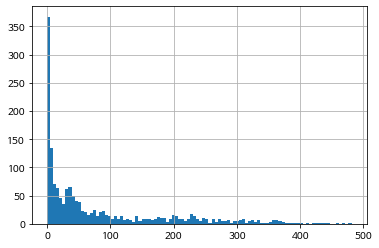

In [ ]:
train.leaf_weight.hist(bins=100)

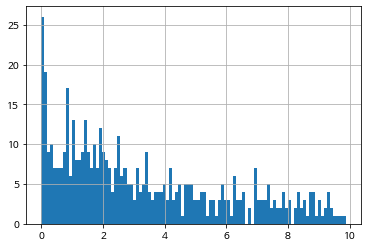

In [ ]:
train.leaf_weight[train.leaf_weight<10].hist(bins=100)

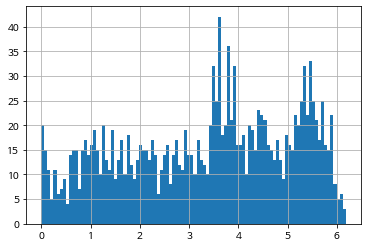

In [ ]:
train.leaf_weight.map(np.log1p).hist(bins=100)

In [ ]:
for path in targetzerolike.img_path:
    pass

#### 3) 판넬 사이즈 전수조사
이제 판넬 사이즈를 계산하는 함수를 만들어 전수조사하겠습니다.

먼저, CASE별 데이터의 수를 확인하겠습니다.

In [ ]:
caseSize = train.groupby('case').size()
caseSize[caseSize > 9]

case
CASE02    11
CASE04    27
CASE05    23
CASE06    11
CASE08    11
CASE10    42
CASE11    41
CASE12    42
CASE13    41
CASE14    41
CASE15    11
CASE18    11
CASE20    12
CASE22    11
CASE25    20
CASE26    47
CASE28    10
CASE30    11
CASE32    26
CASE33    25
CASE34    27
CASE35    27
CASE36    27
CASE37    27
CASE38    28
CASE39    28
CASE40    27
CASE41    27
CASE42    28
CASE43    28
CASE44    27
CASE45    27
CASE46    14
CASE47    11
CASE49    38
CASE50    28
CASE51    28
CASE52    27
CASE53    27
CASE54    28
CASE55    28
CASE56    27
CASE57    27
CASE58    33
CASE59    33
CASE60    34
CASE61    28
CASE62    28
CASE63    24
CASE64    23
CASE67    28
CASE68    28
CASE69    22
CASE70    24
CASE71    32
CASE72    10
CASE73    34
CASE74    27
dtype: int64

이제 case별로 판넬 사이즈를 계산하는 함수를 작성합니다.

In [ ]:
def SearchPanelSize(idxs, dispaly=True):
    boxes, psizes = [], []
    for imgPath in train.img_path[idxs]:
        img = cv2.imread(imgPath)
        squares = find_squares_gray(img)
        boxes.append(squares)
        cv2.drawContours(img, squares, -1, (0, 255, 0), 3)
        # cv2.imshow('squares', img)
        cv2_imshow(img)
        cv2.waitKey(0)
    cv2.destroyAllWindows()

    newboxes, maxareas = [], []
    for idx, boxs in zip(imgIdx, boxes):
        numbox = len(boxs)
        print(f"{train.img_path[idx].split('/')[-1].split('.')[0]}에서 발견된 box의 수는 {numbox}이고,")
        marea, maxbox = 0, None
        newbox = []
        if numbox == 0:
            newboxes.append(newbox)
            maxareas.append(marea)
        else:
            for b in boxs:
                area = cv2.contourArea(b)
                if area > marea:
                    maxbox = b
                    marea = area

            newboxes.append([maxbox])
            maxareas.append(marea)

    print(newboxes)
    print(maxareas)

    for box, imgPath in zip(newboxes, train.img_path[imgIdx]):
        img = cv2.imread(imgPath)
        cv2.drawContours(img, box, -1, (0, 255, 0), 3)
        # cv2.imshow('squares', img)
        cv2_imshow(img)
        cv2.waitKey(0)
    cv2.destroyAllWindows()

In [ ]:
# test_img_path

In [ ]:
# two_img_path, two_meta, two_label = get_train_data('./dataset/temp')

In [ ]:
# two_img_path.sort()

In [ ]:
# two_img_path

In [ ]:
# len(two_img_path)

In [ ]:
all_img_path.sort()

In [ ]:
# all_img_path.extend(two_img_path)

In [ ]:
len(all_img_path)

689

In [ ]:
# for i,j in zip(all_img_path, range(len(all_img_path))):
#   a = i.split('/')
#   b = a[-1].split('.')
#   all_img_path[j] = b[0]
# all_img_path

In [ ]:
# len(all_img_path)

In [ ]:
# all_img_path[-5:]

In [ ]:
total['image_location'] = test_img_path
total

내부온도관측치    외부온도관측치    내부습도관측치    외부습도관측치      CO2관측치     EC관측치  \
0    23.634861  22.564583  69.500486  34.499792  400.265278  0.000000   
1    27.170347  28.738472  63.881805  50.837708  505.823611  0.000000   
2    26.000278  25.541209  79.194857  65.933635  498.605976  1.778848   
3    22.956944  22.361667  70.809792  45.377276  394.612500  0.592409   
4    23.016261  22.531736  73.886944  33.534167  418.561806  0.541303   
..         ...        ...        ...        ...         ...       ...   
455  26.715208  28.278403  59.644167  45.757778  483.540278  0.000000   
456  23.941944  23.810417  69.238194  28.852708  393.603472  0.505359   
457  23.692014  22.628750  80.644236  51.558125  400.667361  0.229255   
458  23.654028  22.580555  75.423958  36.257917  396.872917  0.221151   
459  26.315775  27.297915  83.553440  56.521140  462.731758  0.532402   

           최근분무량  화이트 LED동작강도  레드 LED동작강도  블루 LED동작강도       냉방온도       냉방부하  \
0    6120.690250    47.377587    7.513205   13.499641  22.396963   6.194850   
1     650.293681    33.581327    9.494891    4.720234  23.396068  23.871350   
2     110.823069    47.220974    7.506396   13.524169  20.296656  42.891470   
3    6324.772167    47.357602    7.500712   13.510350  22.395292   2.905725   
4    6478.004611    47.139385    7.486061   13.446429  22.396376   3.182381   
..           ...          ...         ...         ...        ...        ...   
455   757.208444    33.505503    9.448813    4.717489  23.394837  21.598959   
456   735.014965    63.053914   52.313988    5.983643  22.396143   7.724439   
457  5011.328819    47.267908    7.448551   13.535896  22.394994   6.505370   
458  4631.094965    47.187411    7.481375   13.467243  22.395652   6.288787   
459   115.869181    47.892723    7.561983   13.703506  20.302584  44.458071   

          난방온도      난방부하       총추정광량     백색광추정광량    적색광추정광량    청색광추정광량  \
0    20.396963  0.000000  179.654483  146.104933  12.404568  21.144982   
1    22.396068  0.000000  126.722885  103.602093  15.725275   7.395517   
2    17.420928  0.609085  179.639881  146.111980  12.393446  21.134456   
3    20.395292  0.000000  179.414213  145.923088  12.387627  21.103499   
4    20.396376  0.000000  179.532497  146.036713  12.371266  21.124518   
..         ...       ...         ...         ...        ...        ...   
455  22.394837  0.000000  126.669307  103.576911  15.707151   7.385245   
456  20.396143  0.000000  288.376036  193.226108  85.842750   9.307178   
457  20.394994  0.000000  179.430635  145.931828  12.386458  21.112349   
458  20.395652  0.000000  179.480456  145.982085  12.378278  21.120093   
459  17.425382  0.124474  179.850471  146.321128  12.400452  21.128890   

                   image_location  
0    ./dataset/test/image/001.png  
1    ./dataset/test/image/002.png  
2    ./dataset/test/image/003.png  
3    ./dataset/test/image/004.png  
4    ./dataset/test/image/005.png  
..                            ...  
455  ./dataset/test/image/456.png  
456  ./dataset/test/image/457.png  
457  ./dataset/test/image/458.png  
458  ./dataset/test/image/459.png  
459  ./dataset/test/image/460.png  

[460 rows x 19 columns]

In [ ]:
total.columns

Index(['내부온도관측치', '외부온도관측치', '내부습도관측치', '외부습도관측치', 'CO2관측치', 'EC관측치', '최근분무량',
       '화이트 LED동작강도', '레드 LED동작강도', '블루 LED동작강도', '냉방온도', '냉방부하', '난방온도',
       '난방부하', '총추정광량', '백색광추정광량', '적색광추정광량', '청색광추정광량', 'image_location'],
      dtype='object')

In [ ]:
total = total[['image_location', '내부온도관측치', '외부온도관측치', '내부습도관측치', '외부습도관측치', 'CO2관측치', 'EC관측치', '최근분무량',
       '화이트 LED동작강도', '레드 LED동작강도', '블루 LED동작강도', '냉방온도', '냉방부하', '난방온도',
       '난방부하', '총추정광량', '백색광추정광량', '적색광추정광량', '청색광추정광량']]
total

image_location    내부온도관측치    외부온도관측치    내부습도관측치    외부습도관측치  \
0    ./dataset/test/image/001.png  23.634861  22.564583  69.500486  34.499792   
1    ./dataset/test/image/002.png  27.170347  28.738472  63.881805  50.837708   
2    ./dataset/test/image/003.png  26.000278  25.541209  79.194857  65.933635   
3    ./dataset/test/image/004.png  22.956944  22.361667  70.809792  45.377276   
4    ./dataset/test/image/005.png  23.016261  22.531736  73.886944  33.534167   
..                            ...        ...        ...        ...        ...   
455  ./dataset/test/image/456.png  26.715208  28.278403  59.644167  45.757778   
456  ./dataset/test/image/457.png  23.941944  23.810417  69.238194  28.852708   
457  ./dataset/test/image/458.png  23.692014  22.628750  80.644236  51.558125   
458  ./dataset/test/image/459.png  23.654028  22.580555  75.423958  36.257917   
459  ./dataset/test/image/460.png  26.315775  27.297915  83.553440  56.521140   

         CO2관측치     EC관측치        최근분무량  화이트 LED동작강도  레드 LED동작강도  블루 LED동작강도  \
0    400.265278  0.000000  6120.690250    47.377587    7.513205   13.499641   
1    505.823611  0.000000   650.293681    33.581327    9.494891    4.720234   
2    498.605976  1.778848   110.823069    47.220974    7.506396   13.524169   
3    394.612500  0.592409  6324.772167    47.357602    7.500712   13.510350   
4    418.561806  0.541303  6478.004611    47.139385    7.486061   13.446429   
..          ...       ...          ...          ...         ...         ...   
455  483.540278  0.000000   757.208444    33.505503    9.448813    4.717489   
456  393.603472  0.505359   735.014965    63.053914   52.313988    5.983643   
457  400.667361  0.229255  5011.328819    47.267908    7.448551   13.535896   
458  396.872917  0.221151  4631.094965    47.187411    7.481375   13.467243   
459  462.731758  0.532402   115.869181    47.892723    7.561983   13.703506   

          냉방온도       냉방부하       난방온도      난방부하       총추정광량     백색광추정광량  \
0    22.396963   6.194850  20.396963  0.000000  179.654483  146.104933   
1    23.396068  23.871350  22.396068  0.000000  126.722885  103.602093   
2    20.296656  42.891470  17.420928  0.609085  179.639881  146.111980   
3    22.395292   2.905725  20.395292  0.000000  179.414213  145.923088   
4    22.396376   3.182381  20.396376  0.000000  179.532497  146.036713   
..         ...        ...        ...       ...         ...         ...   
455  23.394837  21.598959  22.394837  0.000000  126.669307  103.576911   
456  22.396143   7.724439  20.396143  0.000000  288.376036  193.226108   
457  22.394994   6.505370  20.394994  0.000000  179.430635  145.931828   
458  22.395652   6.288787  20.395652  0.000000  179.480456  145.982085   
459  20.302584  44.458071  17.425382  0.124474  179.850471  146.321128   

       적색광추정광량    청색광추정광량  
0    12.404568  21.144982  
1    15.725275   7.395517  
2    12.393446  21.134456  
3    12.387627  21.103499  
4    12.371266  21.124518  
..         ...        ...  
455  15.707151   7.385245  
456  85.842750   9.307178  
457  12.386458  21.112349  
458  12.378278  21.120093  
459  12.400452  21.128890  

[460 rows x 19 columns]

NameError: ignored

In [ ]:
total.describe()

내부온도관측치      외부온도관측치      내부습도관측치      외부습도관측치       CO2관측치  \
count  1592.000000  1592.000000  1592.000000  1592.000000  1592.000000   
mean     25.995872    25.925181    65.951407    41.449290   487.673636   
std       2.231970     4.949634    13.445782    17.686872    73.307641   
min      20.131458    15.248292    26.960806     3.684119   353.652536   
25%      24.271762    23.038267    55.338200    23.850980   442.164812   
50%      25.695625    25.867459    62.133430    46.376971   473.836044   
75%      27.512812    28.010910    79.430785    54.741994   509.579222   
max      35.073125    76.540375    84.809666    90.008264  1011.107019   

             EC관측치         최근분무량  화이트 LED동작강도   레드 LED동작강도   블루 LED동작강도  \
count  1592.000000   1592.000000  1592.000000  1592.000000  1592.000000   
mean      1.341589   1265.675069    44.956804    11.475243    11.452877   
std       2.428493   2416.211805    24.004286    24.348230    16.417186   
min       0.000000      0.000000     0.000000     0.000000     0.000000   
25%       0.198314    181.915651    40.939157     0.000000     0.000000   
50%       1.163388    698.110611    47.424508     7.489000     9.563698   
75%       1.700327    743.736998    47.970136     9.544512    13.548861   
max      23.872342  43480.808097   201.000000   201.000000   100.000000   

              냉방온도         냉방부하         난방온도         난방부하        총추정광량  \
count  1592.000000  1592.000000  1592.000000  1592.000000  1592.000000   
mean     22.591700    25.580156    20.955460     1.069640   164.346139   
std       1.687439    21.884383     2.149916     4.397269    63.589956   
min      17.414632     0.000000    15.414165     0.000000     0.000000   
25%      22.395407    15.254916    20.394624     0.000000   126.873462   
50%      23.395309    21.530890    22.395255     0.000000   148.161345   
75%      23.397238    32.000794    22.397099     0.346150   179.564677   
max      27.584685   202.875686    22.943524    35.411361   565.348000   

           백색광추정광량      적색광추정광량      청색광추정광량           중량  
count  1592.000000  1592.000000  1592.000000  1592.000000  
mean    129.929056    15.058303    17.956102    80.838052  
std      53.569110    19.376896    25.720584   102.864259  
min       0.000000     0.000000     0.000000     0.000000  
25%     103.639786     0.000000     0.000000     5.836500  
50%     146.093380    12.380855    14.942085    35.088500  
75%     148.108259    15.768068    21.139037   118.851750  
max     309.410000    99.868057   156.650000   481.375000

In [ ]:
total.to_csv('total_train.csv')